# REFMAP laboratory listening test 1 analysis: Exploratory data analysis — Part A data

## Setup

In [1]:
# import statements
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from numpy.random import Generator, PCG64

In [295]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

numpy_randomGen = Generator(PCG64(303))
stats.t.random_state = numpy_randomGen

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 


Set the saveplots toggle to True if plot saving is desired:

In [23]:
saveplots=True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

## Import data and organise

In [5]:
# import data
fileExts = "*.csv"

# Part A
dataByStimAFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataA_ByStim.csv",
                                                       caption=r"Open refmap_listest1_testdataA_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestA = pd.read_csv(dataByStimAFilePath, index_col=0)

# Part A notice data subselection
dataByStimANoticeFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataANoticeFilt_ByStim.csv",
                                                             caption=r"Open refmap_listest1_testdataANoticeFilt_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestANotice = pd.read_csv(dataByStimANoticeFilePath, index_col=0)

# Part A
partADataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataA_BySubj.csv",
                                                     caption=r"Open refmap_listest1_testdataA_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partADataBySubj = pd.read_csv(partADataFilePath, index_col=False)

# Part A notice data subselection
partANoticeDataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataANoticeFilt_BySubj.csv",
                                                           caption=r"Open refmap_listest1_testdataANoticeFilt_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partANoticeDataBySubj = pd.read_csv(partANoticeDataFilePath, index_col=False)


In [6]:
# categorise columns

for dataset in [dataByStimTestA, dataByStimTestANotice, partADataBySubj, partANoticeDataBySubj]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"])
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "-16", "-10", "-4", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Flyby", "Landing", "Takeoff"])
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "M300", "T150"])


## Exploratory data analysis

In this section, exploratory plots are used to examine the Part A data for information and possible trends.

Responses are analysed using violin and scatter plots, segregating the data by the categorical variables UAS LAeq, Ambient environment type, UAS/Ambient signal-noise-ratio, UAS type, and flight operation type.

Noticeability of UAS is investigated using violin and scatter plots.

### Annoyance distribution relative to UAS LAeq

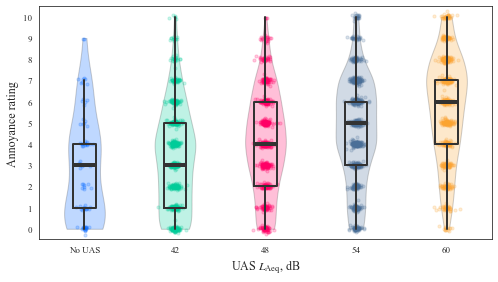

In [7]:
UASLAeqCats = list(partADataBySubj['UASLAeq'].sort_values().unique())

fig, ax = plt.subplots(figsize=(7, 4))

y_data = [partADataBySubj[partADataBySubj['UASLAeq']
                          == LAeq]['Annoyance'].values
          for LAeq in UASLAeqCats]

xjitter = 0.03
yjitter = 0.06
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=xjitter).rvs(len(x)) for x in x_data]
y_jittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y)) for y in y_data]

violins = ax.violinplot(y_data,
                        positions=range(0, len(UASLAeqCats)),
                        widths=0.45,
                        bw_method='scott',
                        showmeans=False,
                        showmedians=False,
                        showextrema=False)
for ii, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(mycolours[ii])
    pc.set_edgecolor([0.25, 0.25, 0.25])
    pc.set_linewidth(1)
    pc.set_alpha(0.25)

medianprops = dict(linewidth=4,
                   color=[0.2, 0.2, 0.2],
                   solid_capstyle="butt")

boxprops = dict(linewidth=2,
                color=[0.2, 0.2, 0.2])

ax.boxplot(y_data,
           positions=range(0, len(UASLAeqCats)),
           showfliers=False,
           showcaps=False,
           medianprops=medianprops,
           whiskerprops=boxprops,
           boxprops=boxprops,
           widths=0.25)

# Add jittered dots
for x, y, color in zip(x_jittered, y_jittered, mycolours[0:len(UASLAeqCats)]):
    ax.scatter(x, y, s=10, color=color, alpha=0.2)

ax.set(yticks=range(0, 11), xticks=range(0, len(UASLAeqCats)),
       xticklabels=UASLAeqCats,
       xlabel="UAS $L_\\text{Aeq}$, dB",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAAnnoyByLAeq.svg"),
                format='svg')
plt.show()

### Annoyance distribution relative to UAS LAeq, segregated by ambient environment

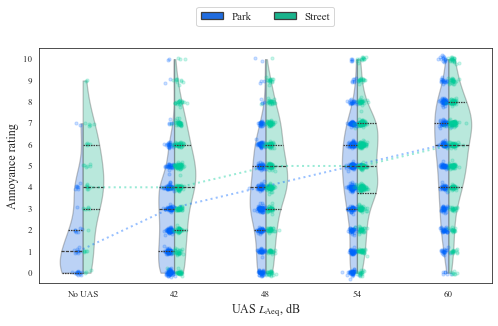

In [8]:
# segregated by ambient environment
UASLAeqCats = list(partADataBySubj['UASLAeq'].sort_values().unique())

fig, ax = plt.subplots(figsize=(7, 4.65))

data = partADataBySubj.loc[:, ['AmbientEnv', 'UASLAeq', 'Annoyance']]
data = data.sort_values('UASLAeq')

sns.violinplot(data=data, y='Annoyance', split=True, hue='AmbientEnv',
               x='UASLAeq', cut=0, palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.02
yjitter = 0.06
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(UASLAeqCats)):
    y_subdataA.append(data.loc[np.logical_and(
                               data['AmbientEnv']
                               == 'Park',
                               data['UASLAeq']
                               == UASLAeqCats[ii]),
                               'Annoyance'].values)
    y_subdataB.append(data.loc[np.logical_and(
                               data['AmbientEnv']
                               == 'Street',
                               data['UASLAeq']
                               == UASLAeqCats[ii]),
                               'Annoyance'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d))
              for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
               for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
               for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
               for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
               for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)

# add median tracing lines
ax.plot([np.median(x, axis=0) - 0.05 for x in x_subdataA],
        [np.median(y, axis=0) for y in y_subdataA], ':', color=mycolours[0], alpha=0.4,
        linewidth=2)
ax.plot([np.median(x, axis=0) + 0.05 for x in x_subdataB],
        [np.median(y, axis=0) for y in y_subdataB], ':', color=mycolours[1], alpha=0.4,
        linewidth=2)

ax.set(yticks=range(0, 11), xticks=range(0, len(UASLAeqCats)),
       xticklabels=UASLAeqCats, xlabel="UAS $L_\\text{Aeq}$, dB",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAAnnoyByLAeqByAmb.svg"),
                format='svg')
plt.show()


### Annoyance distribution relative to UAS/ambient SNR

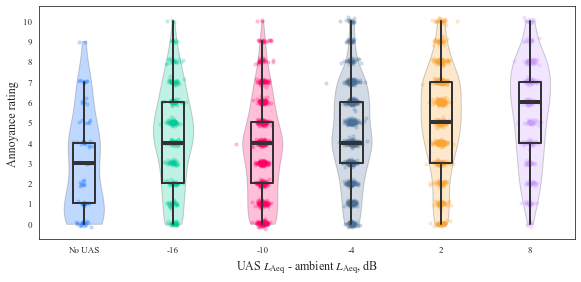

In [9]:
fig, ax = plt.subplots(figsize=(8.15, 4))

SNRCats = list(partADataBySubj['SNRlevel'].sort_values().unique())

y_data = [partADataBySubj[partADataBySubj['SNRlevel']
                          == SNR]['Annoyance'].values
          for SNR in SNRCats]

violins = ax.violinplot(y_data,
                        positions=range(0, len(SNRCats)),
                        widths=0.45,
                        bw_method='scott',
                        showmeans=False,
                        showmedians=False,
                        showextrema=False)
for ii, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(mycolours[ii])
    pc.set_edgecolor([0.25, 0.25, 0.25])
    pc.set_linewidth(1)
    pc.set_alpha(0.25)

medianprops = dict(linewidth=4,
                   color=[0.2, 0.2, 0.2],
                   solid_capstyle="butt")

boxprops = dict(linewidth=2,
                color=[0.2, 0.2, 0.2])

ax.boxplot(y_data,
           positions=range(0, len(SNRCats)),
           showfliers=False,
           showcaps=False,
           medianprops=medianprops,
           whiskerprops=boxprops,
           boxprops=boxprops,
           widths=0.25)

# Add jittered dots
xjitter = 0.03
yjitter = 0.06
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=xjitter).rvs(len(x)) for x in x_data]
y_jittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y)) for y in y_data]
for x, y, color in zip(x_jittered, y_jittered, mycolours[0:len(SNRCats)]):
    ax.scatter(x, y, s=10, color=color, alpha=0.2)

ax.set(yticks=range(0, 11), xticks=range(0, len(SNRCats)),
       xticklabels=SNRCats,
       xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
       ylabel="Annoyance rating")
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAAnnoyBySNR.svg"),
                format='svg')
plt.show()


### Annoyance distribution relative to UAS/ambient SNR, segregated by ambient environment

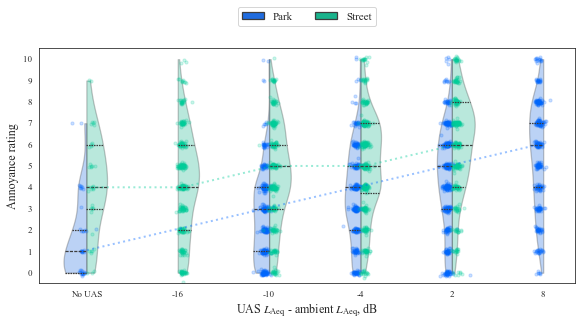

In [10]:
# segregated by ambient environment
fig, ax = plt.subplots(figsize=(8.15, 4.65))

SNRCats = list(partADataBySubj['SNRlevel'].sort_values().unique())

data = partADataBySubj.loc[:, ['AmbientEnv', 'SNRlevel', 'Annoyance']]
data = data.sort_values('SNRlevel')

sns.violinplot(data=data, y='Annoyance', split=True, hue='AmbientEnv',
               x='SNRlevel', cut=0, palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.02
yjitter = 0.06
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(SNRCats)):
    y_subdataA.append(data.loc[np.logical_and(data['AmbientEnv']
                                              == 'Park',
                                              data['SNRlevel']
                                              == SNRCats[ii]),
                                              'Annoyance'].values)
    y_subdataB.append(data.loc[np.logical_and(data['AmbientEnv']
                                              == 'Street',
                                              data['SNRlevel']
                                              == SNRCats[ii]),
                                              'Annoyance'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d))
              for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
               for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
               for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
               for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                    for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)

# add median tracing lines
ax.plot([np.median(x, axis=0) - 0.05 for x in x_subdataA if x.size != 0],
        [np.median(y, axis=0) for y in y_subdataA if y.size != 0], ':', color=mycolours[0], alpha=0.4,
        linewidth=2)
ax.plot([np.median(x, axis=0) + 0.05 for x in x_subdataB if x.size != 0],
        [np.median(y, axis=0) for y in y_subdataB if y.size != 0], ':', color=mycolours[1], alpha=0.4,
        linewidth=2)

ax.set(yticks=range(0, 11), xticks=range(0, len(SNRCats)), xticklabels=SNRCats,
       xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAAnnoyBySNRByAmb.svg"),
                format='svg')
plt.show()

This violin plot indicates that annoyance is related to the UAS SNR, and that the relation varies depending on the ambient environment.

#### Repeat analysis with change in annoyance

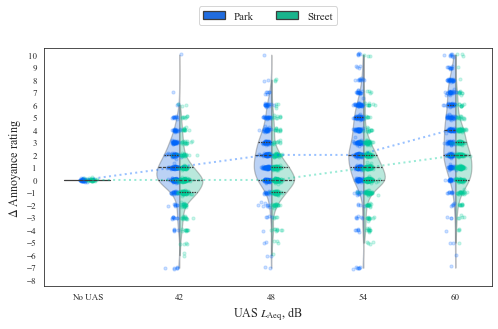

In [24]:
# segregated by ambient environment
UASLAeqCats = list(partADataBySubj['UASLAeq'].sort_values().unique())

fig, ax = plt.subplots(figsize=(7, 4.65))

data = partADataBySubj.loc[:, ['AmbientEnv', 'UASLAeq', 'dAnnoyance']]
data = data.sort_values('UASLAeq')

sns.violinplot(data=data, y='dAnnoyance', split=True, hue='AmbientEnv',
               x='UASLAeq', cut=0, palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.02
yjitter = 0.06
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(UASLAeqCats)):
    y_subdataA.append(data.loc[np.logical_and(
                               data['AmbientEnv']
                               == 'Park',
                               data['UASLAeq']
                               == UASLAeqCats[ii]),
                               'dAnnoyance'].values)
    y_subdataB.append(data.loc[np.logical_and(
                               data['AmbientEnv']
                               == 'Street',
                               data['UASLAeq']
                               == UASLAeqCats[ii]),
                               'dAnnoyance'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d))
              for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
               for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
               for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
               for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
               for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)

# add median tracing lines
ax.plot([np.median(x, axis=0) - 0.05 for x in x_subdataA],
        [np.median(y, axis=0) for y in y_subdataA], ':', color=mycolours[0], alpha=0.4,
        linewidth=2)
ax.plot([np.median(x, axis=0) + 0.05 for x in x_subdataB],
        [np.median(y, axis=0) for y in y_subdataB], ':', color=mycolours[1], alpha=0.4,
        linewidth=2)

ax.set(yticks=range(-10, 11), xticks=range(0, len(UASLAeqCats)),
       xticklabels=UASLAeqCats, xlabel="UAS $L_\\text{Aeq}$, dB",
       ylabel=r"$\Delta$ Annoyance rating", ylim=[-8.5, 10.5])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAdAnnoyByLAeqByAmb.svg"),
                format='svg')
plt.show()


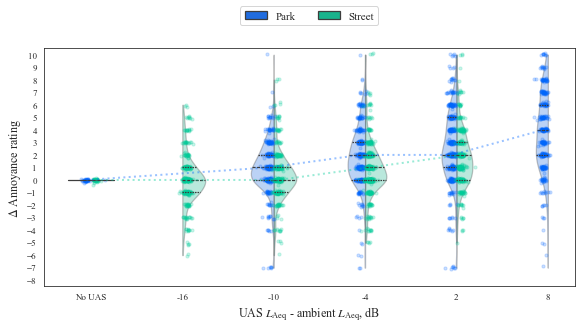

In [25]:
# segregated by ambient environment
fig, ax = plt.subplots(figsize=(8.15, 4.65))

SNRCats = list(partADataBySubj['SNRlevel'].sort_values().unique())

data = partADataBySubj.loc[:, ['AmbientEnv', 'SNRlevel', 'dAnnoyance']]
data = data.sort_values('SNRlevel')

sns.violinplot(data=data, y='dAnnoyance', split=True, hue='AmbientEnv',
               x='SNRlevel', cut=0, palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.02
yjitter = 0.06
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(SNRCats)):
    y_subdataA.append(data.loc[np.logical_and(data['AmbientEnv']
                                              == 'Park',
                                              data['SNRlevel']
                                              == SNRCats[ii]),
                                              'dAnnoyance'].values)
    y_subdataB.append(data.loc[np.logical_and(data['AmbientEnv']
                                              == 'Street',
                                              data['SNRlevel']
                                              == SNRCats[ii]),
                                              'dAnnoyance'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d))
              for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
               for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
               for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
               for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                    for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)

# add median tracing lines
ax.plot([np.median(x, axis=0) - 0.05 for x in x_subdataA if x.size != 0],
        [np.median(y, axis=0) for y in y_subdataA if y.size != 0], ':', color=mycolours[0], alpha=0.4,
        linewidth=2)
ax.plot([np.median(x, axis=0) + 0.05 for x in x_subdataB if x.size != 0],
        [np.median(y, axis=0) for y in y_subdataB if y.size != 0], ':', color=mycolours[1], alpha=0.4,
        linewidth=2)

ax.set(yticks=range(-10, 11), xticks=range(0, len(SNRCats)), xticklabels=SNRCats,
       xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
       ylabel=r"$\Delta$ Annoyance rating", ylim=[-8.5, 10.5])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAdAnnoyBySNRByAmb.svg"),
                format='svg')
plt.show()

### Annoyance relative to UAS flight operation

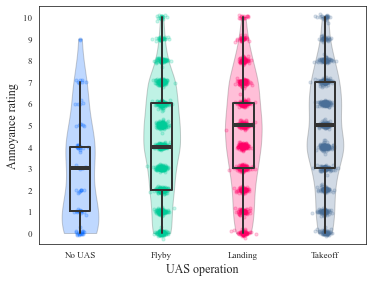

In [51]:
# Flight ops
# ----------
fig, ax = plt.subplots(figsize=(5.25, 4))

opCats = ["No UAS", "Flyby", "Landing", "Takeoff"]

y_data = [partADataBySubj[partADataBySubj['UASOperation']
                          == op]['Annoyance'].values
          for op in opCats]

xjitter = 0.03
yjitter = 0.06
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=xjitter).rvs(len(x)) for x in x_data]
y_jittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y)) for y in y_data]

violins = ax.violinplot(y_data,
                        positions=range(0, len(opCats)),
                        widths=0.45,
                        bw_method='scott',
                        showmeans=False,
                        showmedians=False,
                        showextrema=False)
for ii, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(mycolours[ii])
    pc.set_edgecolor([0.25, 0.25, 0.25])
    pc.set_linewidth(1)
    pc.set_alpha(0.25)

medianprops = dict(linewidth=4,
                   color=[0.2, 0.2, 0.2],
                   solid_capstyle="butt")

boxprops = dict(linewidth=2,
                color=[0.2, 0.2, 0.2])

ax.boxplot(y_data,
           positions=range(0, len(opCats)),
           showfliers=False,
           showcaps=False,
           medianprops=medianprops,
           whiskerprops=boxprops,
           boxprops=boxprops,
           widths=0.25)

# Add jittered dots
for x, y, color in zip(x_jittered, y_jittered, mycolours[0:len(opCats)]):
    ax.scatter(x, y, s=10, color=color, alpha=0.2)

ax.set(yticks=range(0, 11), xticks=range(0, len(opCats)),
       xticklabels=opCats,
       xlabel="UAS operation",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAAnnoyByOp.svg"),
                format='svg')
plt.show()


The violin plot suggests that landing and takeoff are similarly annoying, and slightly more annoying that flyovers.

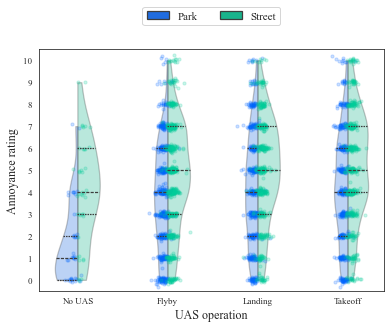

In [52]:
# Flight ops segregated by ambient environment
# --------------------------------------------

opCats = ["No UAS", "Flyby", "Landing", "Takeoff"]

fig, ax = plt.subplots(figsize=(5.5, 4.65))

data = partADataBySubj.loc[:, ['AmbientEnv', 'UASOperation', 'Annoyance']]
data = data.sort_values(by=['AmbientEnv', 'UASOperation'])

sns.violinplot(data=data, y='Annoyance', split=True, hue='AmbientEnv',
               x='UASOperation', cut=0, palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.03
yjitter = 0.06
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(opCats)):
    y_subdataA.append(data.loc[np.logical_and(
                                  data['AmbientEnv']
                                  == 'Park',
                                  data['UASOperation']
                                  == opCats[ii]),
                                  'Annoyance'].values)
    y_subdataB.append(data.loc[np.logical_and(
                                    data['AmbientEnv']
                                    == 'Street',
                                    data['UASOperation']
                                    == opCats[ii]),
                                    'Annoyance'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d))
                   for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                  for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                  for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                    for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                    for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)

ax.set(yticks=range(0, 11), xticks=range(0, len(opCats)), xticklabels=opCats,
       xlabel="UAS operation",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAAnnoyByOpByAmb.svg"),
                format='svg')
plt.show()

The segregated violin plot suggests the operation distinction may be an analysis artefact? - only takeoff appears to be marginally higher for street

### Annoyance relative to UAS type

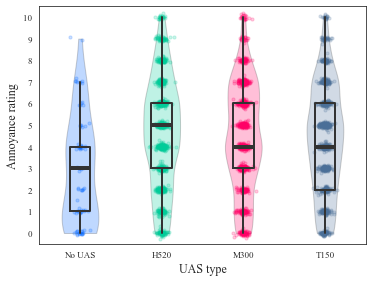

In [53]:
# by UAS type
fig, ax = plt.subplots(figsize=(5.25, 4))

vehicleCats = ["No UAS", "H520", "M300", "T150"]

y_data = [partADataBySubj[partADataBySubj['UASType']
                          == vehicle]['Annoyance'].values
          for vehicle in vehicleCats]

xjitter = 0.03
yjitter = 0.06
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=xjitter).rvs(len(x)) for x in x_data]
y_jittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y)) for y in y_data]

violins = ax.violinplot(y_data,
                        positions=range(0, len(vehicleCats)),
                        widths=0.45,
                        bw_method='scott',
                        showmeans=False,
                        showmedians=False,
                        showextrema=False)
for ii, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(mycolours[ii])
    pc.set_edgecolor([0.25, 0.25, 0.25])
    pc.set_linewidth(1)
    pc.set_alpha(0.25)

medianprops = dict(linewidth=4,
                   color=[0.2, 0.2, 0.2],
                   solid_capstyle="butt")

boxprops = dict(linewidth=2,
                color=[0.2, 0.2, 0.2])

ax.boxplot(y_data,
           positions=range(0, len(vehicleCats)),
           showfliers=False,
           showcaps=False,
           medianprops=medianprops,
           whiskerprops=boxprops,
           boxprops=boxprops,
           widths=0.25)

# Add jittered dots
for x, y, color in zip(x_jittered, y_jittered, mycolours[0:len(vehicleCats)]):
    ax.scatter(x, y, s=10, color=color, alpha=0.2)

ax.set(yticks=range(0, 11), xticks=range(0, len(vehicleCats)),
       xticklabels=vehicleCats,
       xlabel="UAS type",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAAnnoyByType.svg"),
                format='svg')
plt.show()

The violin plot suggests the Yuneec H520E tends to be rated more annoying than the other UAS.

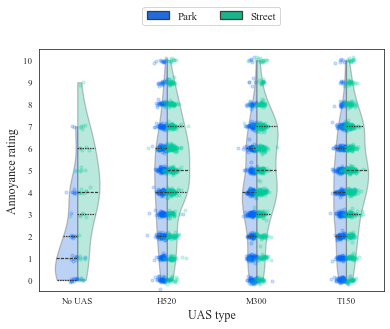

In [56]:
# UAS type segregated by ambient environment
# --------------------------------------------

vehicleCats = ["No UAS", "H520", "M300", "T150"]

fig, ax = plt.subplots(figsize=(5.5, 4.65))

data = partADataBySubj.loc[:, ['AmbientEnv', 'UASType', 'Annoyance']]
data = data.sort_values(by=['AmbientEnv', 'UASType'])

sns.violinplot(data=data, y='Annoyance', split=True, hue='AmbientEnv',
               x='UASType', cut=0, palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.03
yjitter = 0.06
y_subdataPark = list()
y_subdataStreet = list()
for ii in range(0, len(vehicleCats)):
    y_subdataPark.append(data.loc[np.logical_and(
                                  data['AmbientEnv']
                                  == 'Park',
                                  data['UASType']
                                  == vehicleCats[ii]),
                                  'Annoyance'].values)
    y_subdataStreet.append(data.loc[np.logical_and(
                                    data['AmbientEnv']
                                    == 'Street',
                                    data['UASType']
                                    == vehicleCats[ii]),
                                    'Annoyance'].values)
x_subdataPark = [np.array([i] * len(d)) for i, d in enumerate(y_subdataPark)]
x_subdataStreet = [np.array([i] * len(d))
                   for i, d in enumerate(y_subdataStreet)]
x_Parkjittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                  for x in x_subdataPark]
y_Parkjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                  for y in y_subdataPark]
x_Streetjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                    for x in x_subdataStreet]
y_Streetjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                    for y in y_subdataStreet]
for x, y in zip(x_Parkjittered, y_Parkjittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
for x, y in zip(x_Streetjittered, y_Streetjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)

ax.set(yticks=range(0, 11), xticks=range(0, len(vehicleCats)), xticklabels=vehicleCats,
       xlabel="UAS type",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAAnnoyByTypeByAmb.svg"),
                format='svg')
plt.show()

The violin plot segregated by ambient environment suggests there is very little difference between the types.

Scatter plots by UAS type and flight operation, segegated by environment:

In [285]:
# prepare subset of data
partADataBySubj['UASTypeOp'] = partADataBySubj['UASType'].astype(str) + " " + partADataBySubj['UASOperation'].astype(str)
partADataBySubj.loc[partADataBySubj['UASTypeOp'] == "No UAS No UAS", 'UASTypeOp'] = "No UAS"
UASTypeOpCats = ["No UAS", "H520 Flyby", "M300 Flyby", "T150 Flyby", "H520 Landing", "M300 Landing", "T150 Landing",
                 "H520 Takeoff", "M300 Takeoff", "T150 Takeoff"]

partADataBySubj['UASTypeOp'] = pd.Categorical(partADataBySubj['UASTypeOp'], UASTypeOpCats)



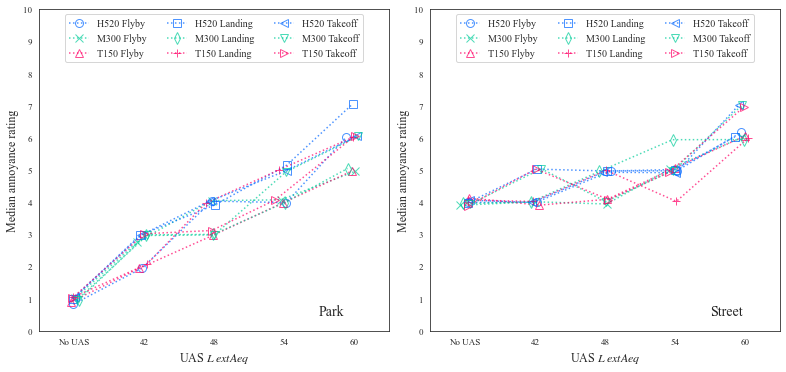

In [288]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5.25))

data = partADataBySubj.loc[:, ['UASLAeq', 'AmbientEnv', 'UASTypeOp', 'Annoyance']]
LAeqCats = list(data['UASLAeq'].sort_values().unique())

markers = ['o', 'x', '^', 's', 'd', '+', '<', 'v', '>']
mycolourloop = mycolours[0:3] + mycolours[0:3] + mycolours[0:3]

xjitter = 0.05
yjitter = 0.05

for iiEnv, Env in enumerate(list(data['AmbientEnv'].sort_values().unique())):
    ax = axs[iiEnv]
    subdata = pd.DataFrame(index=UASTypeOpCats, columns=LAeqCats)
    for jjCat, typeOpCat in enumerate(UASTypeOpCats):
        for LAeqCat in LAeqCats:
            subdata.loc[typeOpCat, LAeqCat] = data.loc[np.logical_and(data['UASTypeOp'] == typeOpCat,
                                                                      np.logical_and(data['UASLAeq'] == LAeqCat,
                                                                      data['AmbientEnv'] == Env)), 'Annoyance'].median()
        subdata.iloc[0, :] = subdata.iloc[0, 0]
        subdata.iloc[:, 0] = subdata.iloc[0, 0]

        if typeOpCat != "No UAS":
            x_jitter = stats.t(df=6, scale=xjitter).rvs(len(LAeqCats))
            y_jitter = stats.t(df=6, scale=yjitter).rvs(len(subdata.loc[typeOpCat, :]))
            ax.plot(range(0, len(LAeqCats)) + x_jitter, subdata.loc[typeOpCat, :] + y_jitter, color=mycolourloop[jjCat - 1], label=typeOpCat,
                    linestyle=':', marker=markers[jjCat - 1], markersize=8, markerfacecolor='none', alpha=0.7)

    ax.set(xticks=range(0, len(LAeqCats)), xticklabels=LAeqCats, xlim=[-0.5, len(LAeqCats)-0.5], yticks=range(0, 11, 1),
           xlabel="UAS $L_\text{Aeq}$",
           ylabel="Median annoyance rating")
    ax.text(x=3.5, y=0.5, s=Env, fontsize=14)
    ax.legend(fontsize=10, loc='upper center', ncol=3)

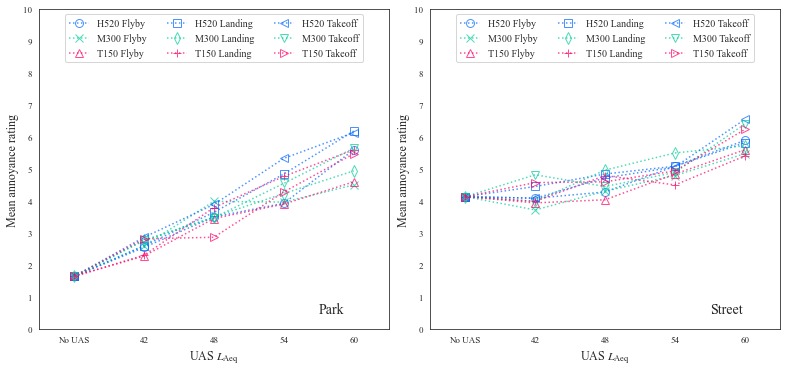

In [271]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5.25))

data = partADataBySubj.loc[:, ['UASLAeq', 'AmbientEnv', 'UASTypeOp', 'Annoyance']]
LAeqCats = list(data['UASLAeq'].sort_values().unique())

markers = ['o', 'x', '^', 's', 'd', '+', '<', 'v', '>']
mycolourloop = mycolours[0:3] + mycolours[0:3] + mycolours[0:3]

for iiEnv, Env in enumerate(list(data['AmbientEnv'].sort_values().unique())):
    ax = axs[iiEnv]
    subdata = pd.DataFrame(index=UASTypeOpCats, columns=LAeqCats)
    for jjCat, typeOpCat in enumerate(UASTypeOpCats):
        for LAeqCat in LAeqCats:
            subdata.loc[typeOpCat, LAeqCat] = data.loc[np.logical_and(data['UASTypeOp'] == typeOpCat,
                                                                      np.logical_and(data['UASLAeq'] == LAeqCat,
                                                                      data['AmbientEnv'] == Env)), 'Annoyance'].mean()
        subdata.iloc[0, :] = subdata.iloc[0, 0]
        subdata.iloc[:, 0] = subdata.iloc[0, 0]

        if typeOpCat != "No UAS":
            
            ax.plot(range(0, len(LAeqCats)), subdata.loc[typeOpCat, :], color=mycolourloop[jjCat - 1], label=typeOpCat,
                    linestyle=':', marker=markers[jjCat - 1], markersize=8, markerfacecolor='none', alpha=0.7)

    ax.set(xticks=range(0, len(LAeqCats)), xticklabels=LAeqCats, xlim=[-0.5, len(LAeqCats)-0.5], yticks=range(0, 11, 1),
           xlabel="UAS $L_\text{Aeq}$",
           ylabel="Mean annoyance rating")
    ax.text(x=3.5, y=0.5, s=Env, fontsize=14)
    ax.legend(fontsize=10, ncol=3, loc='upper center')

### Annoyance, valence and arousal related to UAS flight operation

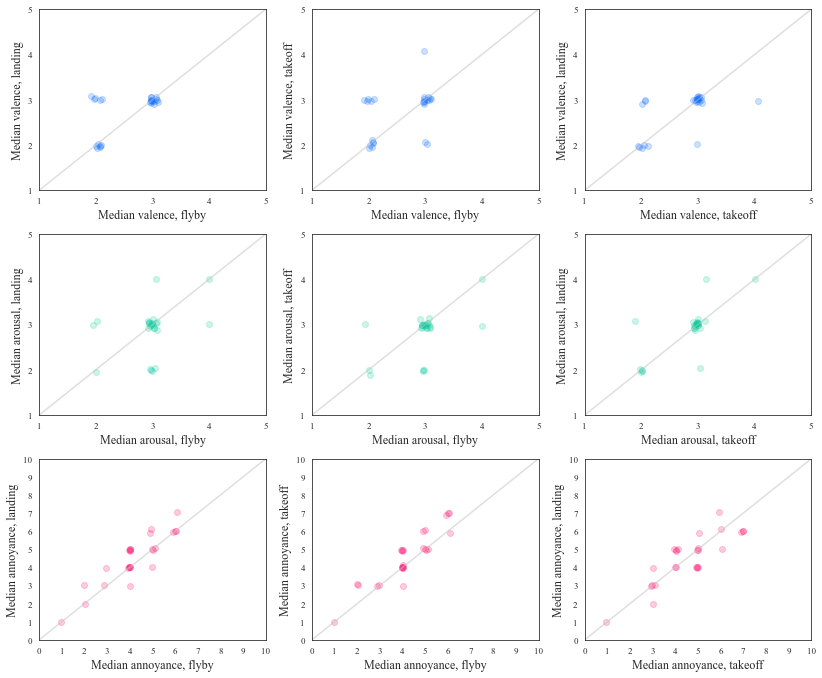

In [19]:
# scatter plots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(11.5, 9.5))
data = dataByStimTestA.loc[dataByStimTestA.index.str.find("PwrScale")
                           == -1, ['UASOperation', 'AmbientEnv',
                                   'SNRlevel', 'ValenceMedian',
                                   'ArousalMedian', 'AnnoyMedian']]
data.sort_index(axis=0, inplace=True)

jitter_amount = 0.05
data_jittered = data.copy()
data_jittered[['ValenceMedian',
               'ArousalMedian',
               'AnnoyMedian']] = (data[['ValenceMedian',
                                        'ArousalMedian',
                                        'AnnoyMedian']]
                                  + np.random.normal(0,
                                                     jitter_amount,
                                                     data[['ValenceMedian',
                                                           'ArousalMedian',
                                                           'AnnoyMedian']].shape))

responseLabels = ["Median valence", "Median arousal", "Median annoyance"]
responseLims = [[1, 5], [1, 5], [0, 10]]
for ii in range(0, 3):
    for jj in range(0, 3):
        axs[ii, jj].plot([-1, 10], [-1, 10], color=[0.75, 0.75, 0.75],
                         alpha=0.5)

for ii, (response, colour) in enumerate(zip(['ArousalMedian', 'ValenceMedian',
                                             'AnnoyMedian'],
                                            [mycolours[0], mycolours[1],
                                             mycolours[2]])):
    for jj, operation in enumerate([['Flyby', 'Landing'], ['Flyby', 'Takeoff'],
                                    ['Takeoff', 'Landing']]):
        axs[ii, jj].scatter(data_jittered.loc[data['UASOperation'].isin(['No UAS',
                                                                         operation[0]])].loc[:,
                                                                                             response],
                            data_jittered.loc[data['UASOperation'].isin(['No UAS',
                                                                         operation[1]])].loc[:,
                                                                                             response],
                            alpha=0.2, color=colour)
        axs[ii, jj].set(xticks=range(0, 11), yticks=range(0, 11),
                        xlim=responseLims[ii], ylim=responseLims[ii],
                        xlabel=responseLabels[ii] + ", "
                        + operation[0].lower(),
                        ylabel=responseLabels[ii] + ", "
                        + operation[1].lower())

plt.show()


This set of scatter plots indicates that while annoyance may be higher for landing and takeoff compared with annoyance, this relationship is not consistent in terms of valence or arousal.

### Valence and arousal related to UAS LAeq

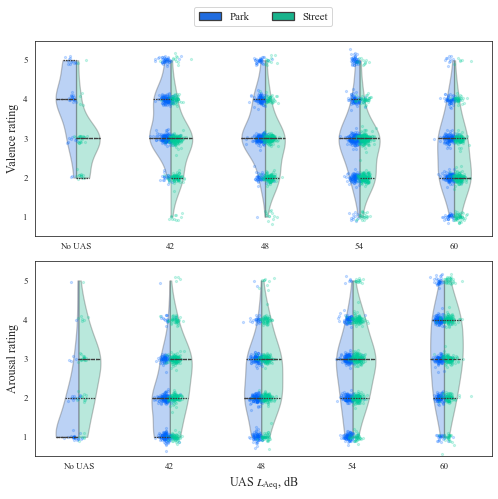

In [20]:
# UAS LAeq

UASLAeqCats = list(partADataBySubj['UASLAeq'].sort_values().unique())

# segregated by ambient environment
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))

data0 = partADataBySubj.loc[:, ['AmbientEnv', 'UASLAeq', 'Valence']]
data0 = data0.sort_values('UASLAeq')
data1 = partADataBySubj.loc[:, ['AmbientEnv', 'UASLAeq', 'Arousal']]
data1 = data1.sort_values('UASLAeq')

sns.violinplot(ax=axs[0], data=data0, y='Valence', split=True,
               hue='AmbientEnv', x='UASLAeq', cut=0,
               palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method=0.55, legend=True)
sns.violinplot(ax=axs[1], data=data1, y='Arousal', split=True,
               hue='AmbientEnv', x='UASLAeq', cut=0,
               palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method=0.55, legend=False)

plt.setp(axs[0].collections, alpha=0.3)
plt.setp(axs[1].collections, alpha=0.3)
# Add jittered dots
y_subdata0Park = list()
y_subdata0Street = list()
y_subdata1Park = list()
y_subdata1Street = list()
for ii in range(0, len(UASLAeqCats)):
    y_subdata0Park.append(partADataBySubj.loc[np.logical_and(
                                              partADataBySubj['AmbientEnv']
                                              == 'Park',
                                              partADataBySubj['UASLAeq']
                                              == UASLAeqCats[ii]),
                                              'Valence'].values)
    y_subdata0Street.append(partADataBySubj.loc[np.logical_and(
                                                partADataBySubj['AmbientEnv']
                                                == 'Street',
                                                partADataBySubj['UASLAeq']
                                                == UASLAeqCats[ii]),
                                                'Valence'].values)
    y_subdata1Park.append(partADataBySubj.loc[np.logical_and(
                                              partADataBySubj['AmbientEnv']
                                              == 'Park',
                                              partADataBySubj['UASLAeq']
                                              == UASLAeqCats[ii]),
                                              'Arousal'].values)
    y_subdata1Street.append(partADataBySubj.loc[np.logical_and(
                                                partADataBySubj['AmbientEnv']
                                                == 'Street',
                                                partADataBySubj['UASLAeq']
                                                == UASLAeqCats[ii]),
                                                'Arousal'].values)
x_subdata0Park = [np.array([i] * len(d)) for i, d in enumerate(y_subdata0Park)]
x_subdata0Street = [np.array([i] * len(d))
                    for i, d in enumerate(y_subdata0Street)]
x0_Parkjittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                   for x in x_subdata0Park]
y0_Parkjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                   for y in y_subdata0Park]
x0_Streetjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                     for x in x_subdata0Street]
y0_Streetjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                     for y in y_subdata0Street]
for x, y in zip(x0_Parkjittered, y0_Parkjittered):
    axs[0].scatter(x, y, s=5, color=mycolours[0], alpha=0.2)
for x, y in zip(x0_Streetjittered, y0_Streetjittered):
    axs[0].scatter(x, y, s=5, color=mycolours[1], alpha=0.2)
x_subdata1Park = [np.array([i] * len(d)) for i, d in enumerate(y_subdata1Park)]
x_subdata1Street = [np.array([i] * len(d))
                    for i, d in enumerate(y_subdata1Street)]
x1_Parkjittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                   for x in x_subdata1Park]
y1_Parkjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                   for y in y_subdata1Park]
x1_Streetjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                     for x in x_subdata1Street]
y1_Streetjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                     for y in y_subdata1Street]
for x, y in zip(x1_Parkjittered, y1_Parkjittered):
    axs[1].scatter(x, y, s=5, color=mycolours[0], alpha=0.2)
for x, y in zip(x1_Streetjittered, y1_Streetjittered):
    axs[1].scatter(x, y, s=5, color=mycolours[1], alpha=0.2)

axs[0].set(yticks=range(1, 6), xticks=range(0, len(UASLAeqCats)),
           xticklabels=UASLAeqCats, xlabel=None,
           ylabel="Valence rating", ylim=[0.5, 5.5])
axs[1].set(yticks=range(1, 6), xticks=range(0, len(UASLAeqCats)),
           xticklabels=UASLAeqCats, xlabel="UAS $L_\\mathrm{Aeq}$, dB",
           ylabel="Arousal rating", ylim=[0.5, 5.5])
axs[0].legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2,
              fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAValenceArousalByLAeq.svg"),
                format='svg')
plt.show()


### Valence and arousal related to UAS/ambient SNR

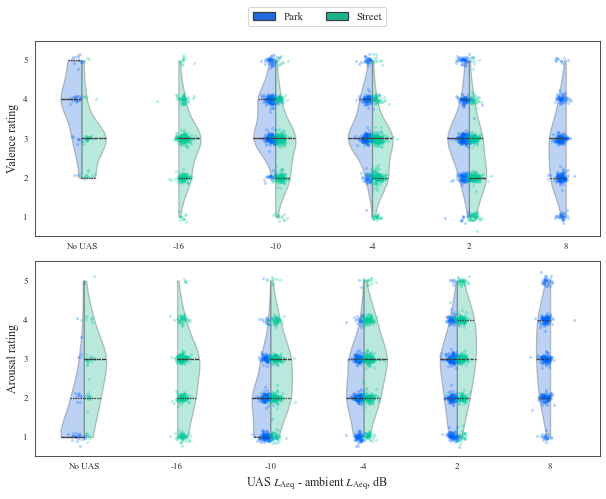

In [21]:
# UAS SNR

SNRCats = list(partADataBySubj['SNRlevel'].sort_values().unique())

# segregated by ambient environment
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8.5, 7))

data0 = partADataBySubj.loc[:, ['AmbientEnv', 'SNRlevel', 'Valence']]
data0 = data0.sort_values('SNRlevel')
data1 = partADataBySubj.loc[:, ['AmbientEnv', 'SNRlevel', 'Arousal']]
data1 = data1.sort_values('SNRlevel')

sns.violinplot(ax=axs[0], data=data0, y='Valence', split=True,
               hue='AmbientEnv', x='SNRlevel', cut=0,
               palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method=0.55, legend=True)
sns.violinplot(ax=axs[1], data=data1, y='Arousal', split=True,
               hue='AmbientEnv', x='SNRlevel', cut=0,
               palette=mycolours[0:2], inner='quart',
               width=0.5, bw_method=0.55, legend=False)

plt.setp(axs[0].collections, alpha=0.3)
plt.setp(axs[1].collections, alpha=0.3)
# Add jittered dots
y_subdata0Park = list()
y_subdata0Street = list()
y_subdata1Park = list()
y_subdata1Street = list()
for ii in range(0, len(SNRCats)):
    y_subdata0Park.append(partADataBySubj.loc[np.logical_and(
                                              partADataBySubj['AmbientEnv']
                                              == 'Park',
                                              partADataBySubj['SNRlevel']
                                              == SNRCats[ii]),
                                              'Valence'].values)
    y_subdata0Street.append(partADataBySubj.loc[np.logical_and(
                                                partADataBySubj['AmbientEnv']
                                                == 'Street',
                                                partADataBySubj['SNRlevel']
                                                == SNRCats[ii]),
                                                'Valence'].values)
    y_subdata1Park.append(partADataBySubj.loc[np.logical_and(
                                              partADataBySubj['AmbientEnv']
                                              == 'Park',
                                              partADataBySubj['SNRlevel']
                                              == SNRCats[ii]),
                                              'Arousal'].values)
    y_subdata1Street.append(partADataBySubj.loc[np.logical_and(
                                                partADataBySubj['AmbientEnv']
                                                == 'Street',
                                                partADataBySubj['SNRlevel']
                                                == SNRCats[ii]),
                                                'Arousal'].values)
x_subdata0Park = [np.array([i] * len(d)) for i, d in enumerate(y_subdata0Park)]
x_subdata0Street = [np.array([i] * len(d))
                    for i, d in enumerate(y_subdata0Street)]
x0_Parkjittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                   for x in x_subdata0Park]
y0_Parkjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                   for y in y_subdata0Park]
x0_Streetjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                     for x in x_subdata0Street]
y0_Streetjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                     for y in y_subdata0Street]
for x, y in zip(x0_Parkjittered, y0_Parkjittered):
    axs[0].scatter(x, y, s=5, color=mycolours[0], alpha=0.2)
for x, y in zip(x0_Streetjittered, y0_Streetjittered):
    axs[0].scatter(x, y, s=5, color=mycolours[1], alpha=0.2)
x_subdata1Park = [np.array([i] * len(d)) for i, d in enumerate(y_subdata1Park)]
x_subdata1Street = [np.array([i] * len(d))
                    for i, d in enumerate(y_subdata1Street)]
x1_Parkjittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                   for x in x_subdata1Park]
y1_Parkjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                   for y in y_subdata1Park]
x1_Streetjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                     for x in x_subdata1Street]
y1_Streetjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                     for y in y_subdata1Street]
for x, y in zip(x1_Parkjittered, y1_Parkjittered):
    axs[1].scatter(x, y, s=5, color=mycolours[0], alpha=0.2)
for x, y in zip(x1_Streetjittered, y1_Streetjittered):
    axs[1].scatter(x, y, s=5, color=mycolours[1], alpha=0.2)

axs[0].set(yticks=range(1, 6), xticks=range(0, len(SNRCats)),
           xticklabels=SNRCats, xlabel=None,
           ylabel="Valence rating", ylim=[0.5, 5.5])
axs[1].set(yticks=range(1, 6), xticks=range(0, len(SNRCats)),
           xticklabels=SNRCats, xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
           ylabel="Arousal rating", ylim=[0.5, 5.5])
axs[0].legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2,
              fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtAValenceArousalBySNR.svg"),
                format='svg')
plt.show()


### Noticeability related to UAS/ambient SNR

First, using the full dataset, the aggregated proportion of 'UAS noticed' judgements is plotted against SNR. Then this is replotted using the subselection of participants established from the anomalous data checking stage. 

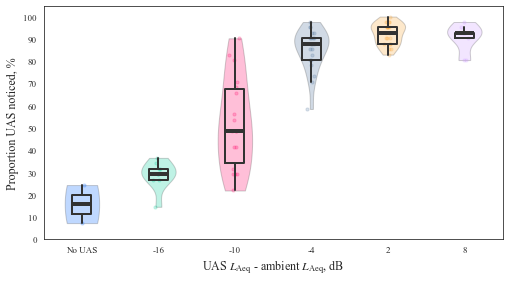

In [22]:
# unfiltered participant selection data
fig, ax = plt.subplots(figsize=(7.15, 4))

SNRCats = list(dataByStimTestA['SNRlevel'].sort_values().unique())

y_data = [dataByStimTestA.loc[dataByStimTestA['SNRlevel']
                              == SNR, 'NoticedProportion'].values
          for SNR in SNRCats]

violins = ax.violinplot(y_data,
                        positions=range(0, len(SNRCats)),
                        widths=0.45,
                        bw_method='scott',
                        showmeans=False,
                        showmedians=False,
                        showextrema=False)
for ii, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(mycolours[ii])
    pc.set_edgecolor([0.25, 0.25, 0.25])
    pc.set_linewidth(1)
    pc.set_alpha(0.25)

medianprops = dict(linewidth=4,
                   color=[0.2, 0.2, 0.2],
                   solid_capstyle="butt")

boxprops = dict(linewidth=2,
                color=[0.2, 0.2, 0.2])

ax.boxplot(y_data,
           positions=range(0, len(SNRCats)),
           showfliers=False,
           showcaps=False,
           medianprops=medianprops,
           whiskerprops=boxprops,
           boxprops=boxprops,
           widths=0.25)

# Add jittered dots
xjitter = 0.02
yjitter = 0.0
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=xjitter).rvs(len(x)) for x in x_data]
y_jittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y)) for y in y_data]
for x, y, color in zip(x_jittered, y_jittered, mycolours[0:len(SNRCats)]):
    ax.scatter(x, y, s=10, color=color, alpha=0.2)

ax.set(yticks=np.arange(0, 1.1, 0.1), yticklabels=range(0, 110, 10),
       xticks=range(0, len(SNRCats)), xticklabels=SNRCats,
       xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
       ylabel="Proportion UAS noticed, %")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsSNRUnfilt.svg"),
                format='svg')
plt.show()


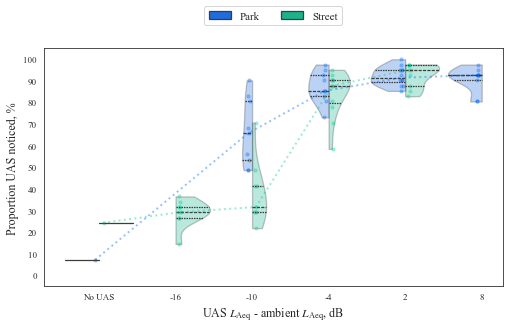

In [151]:
# segregated by ambient environment
fig, ax = plt.subplots(figsize=(7.15, 4.65))

data = dataByStimTestA.loc[:, ['AmbientEnv', 'SNRlevel', 'NoticedProportion']]
data = data.sort_values('AmbientEnv', ignore_index=True)
data = data.sort_values('SNRlevel')


sns.violinplot(data=data, y='NoticedProportion', split=True, hue='AmbientEnv',
               x='SNRlevel', cut=0, palette=mycolours[0:2], inner='quart',
               width=0.9, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.01
yjitter = 0.0
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(SNRCats)):
    y_subdataA.append(data.loc[np.logical_and(
                               data['AmbientEnv']
                               == 'Park',
                               data['SNRlevel']
                               == SNRCats[ii]),
                               'NoticedProportion'].values)
    y_subdataB.append(data.loc[np.logical_and(
                               data['AmbientEnv']
                               == 'Street',
                               data['SNRlevel']
                               == SNRCats[ii]),
                               'NoticedProportion'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d)) for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                  for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                  for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                    for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                    for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.3)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.3)

# add median tracing lines
ax.plot([np.median(x, axis=0) - 0.05 for x in x_subdataA if x.size != 0],
        [np.median(y, axis=0) for y in y_subdataA if y.size != 0], ':', color=mycolours[0], alpha=0.4,
        linewidth=2)
ax.plot([np.median(x, axis=0) + 0.05 for x in x_subdataB if x.size != 0],
        [np.median(y, axis=0) for y in y_subdataB if y.size != 0], ':', color=mycolours[1], alpha=0.4,
        linewidth=2)

ax.set(yticks=np.arange(0, 1.1, 0.1), yticklabels=range(0, 110, 10),
       xticks=range(0, len(SNRCats)), xticklabels=SNRCats,
       xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
       ylabel="Proportion UAS noticed, %", ylim=[-0.05, 1.05])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsSNRByAmbUnfilt.svg"),
                format='svg')
plt.show()

These violin plots illustrate the uncertainty generated by the inclusion of all participants, especially for the 'no UAS' stimuli - for the street environment, around 25% of all these judgements were classified as 'UAS noticed'.

#### Noticeability subset reanalysis 
The following plots are based on the subselected noticeability dataset.

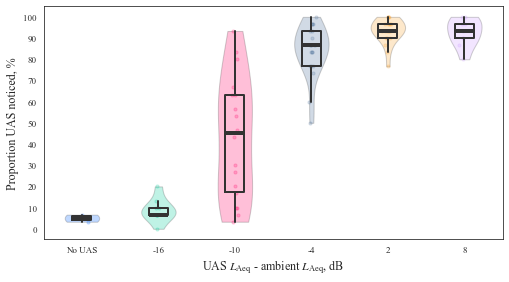

In [24]:
# re-run analysis with recalculated proportion from selected participants
fig, ax = plt.subplots(figsize=(7.15, 4))

SNRCats = list(dataByStimTestA['SNRlevel'].sort_values().unique())

omitParticipants = [2, 5, 21, 32, 34, 36, 38, 39, 40, 44, 45]
omitColumns = ["UAS_noticed_" + str(partID) for partID in omitParticipants]
keepColumns = [col for col in dataByStimTestA.columns[dataByStimTestA.columns.str.find("UAS_noticed_") == 0]
               if col not in omitColumns]
dataByStimTestA['NoticedTotalFilt'] = dataByStimTestA[keepColumns].sum(axis=1)
dataByStimTestA['NoticedPropFilt'] = dataByStimTestA[keepColumns].sum(axis=1)/len(keepColumns)

y_data = [dataByStimTestA.loc[dataByStimTestA['SNRlevel']
                              == SNR, 'NoticedPropFilt'].values
          for SNR in SNRCats]

violins = ax.violinplot(y_data,
                        positions=range(0, len(SNRCats)),
                        widths=0.45,
                        bw_method='scott',
                        showmeans=False,
                        showmedians=False,
                        showextrema=False)
for ii, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(mycolours[ii])
    pc.set_edgecolor([0.25, 0.25, 0.25])
    pc.set_linewidth(1)
    pc.set_alpha(0.25)

medianprops = dict(linewidth=4,
                   color=[0.2, 0.2, 0.2],
                   solid_capstyle="butt")

boxprops = dict(linewidth=2,
                color=[0.2, 0.2, 0.2])

ax.boxplot(y_data,
           positions=range(0, len(SNRCats)),
           showfliers=False,
           showcaps=False,
           medianprops=medianprops,
           whiskerprops=boxprops,
           boxprops=boxprops,
           widths=0.25)

# Add jittered dots
xjitter = 0.02
yjitter = 0.0
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=xjitter).rvs(len(x)) for x in x_data]
y_jittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y)) for y in y_data]
for x, y, color in zip(x_jittered, y_jittered, mycolours[0:len(SNRCats)]):
    ax.scatter(x, y, s=10, color=color, alpha=0.2)

ax.set(yticks=np.arange(0, 1.1, 0.1), yticklabels=range(0, 110, 10),
       xticks=range(0, len(SNRCats)), xticklabels=SNRCats,
       xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
       ylabel="Proportion UAS noticed, %")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsSNRFilt.svg"),
                format='svg')
plt.show()

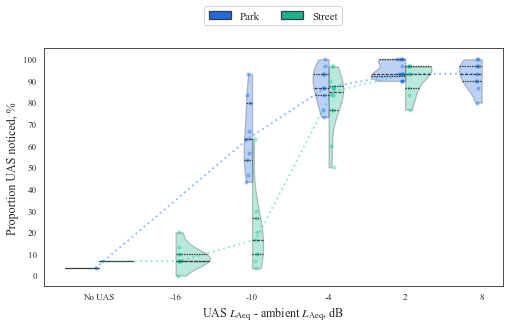

In [83]:
# segregated by ambient environment
fig, ax = plt.subplots(figsize=(7.15, 4.65))

data = dataByStimTestANotice.loc[:, ['AmbientEnv', 'SNRlevel', 'NoticedPropFilt']]
data = data.sort_values('AmbientEnv', ignore_index=True)
data = data.sort_values('SNRlevel')


sns.violinplot(data=data, y='NoticedPropFilt', split=True, hue='AmbientEnv',
               x='SNRlevel', cut=0, palette=mycolours[0:2], inner='quart',
               width=0.9, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.01
yjitter = 0.0
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(SNRCats)):
    y_subdataA.append(data.loc[np.logical_and(
                               data['AmbientEnv']
                               == 'Park',
                               data['SNRlevel']
                               == SNRCats[ii]),
                               'NoticedPropFilt'].values)
    y_subdataB.append(data.loc[np.logical_and(
                               data['AmbientEnv']
                               == 'Street',
                               data['SNRlevel']
                               == SNRCats[ii]),
                               'NoticedPropFilt'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d)) for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                  for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                  for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                    for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                    for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.3)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.3)

# add median tracing lines
ax.plot([np.median(x, axis=0) - 0.05 for x in x_subdataA if x.size != 0],
        [np.median(y, axis=0) for y in y_subdataA if y.size != 0], ':', color=mycolours[0], alpha=0.4,
        linewidth=2)
ax.plot([np.median(x, axis=0) + 0.05 for x in x_subdataB if x.size != 0],
        [np.median(y, axis=0) for y in y_subdataB if y.size != 0], ':', color=mycolours[1], alpha=0.4,
        linewidth=2)

ax.set(yticks=np.arange(0, 1.1, 0.1), yticklabels=range(0, 110, 10),
       xticks=range(0, len(SNRCats)), xticklabels=SNRCats,
       xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
       ylabel="Proportion UAS noticed, %", ylim=[-0.05, 1.05])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsSNRByAmbFilt.svg"),
                format='svg')
plt.show()


These violin plots show a more plausible proportion within the 'no UAS' category, and a greater distinction between the park and street ambient environments, most visibly in the -10 dB category. This indicates that overall SNR alone is not sufficient to explain noticeability in the different environments.

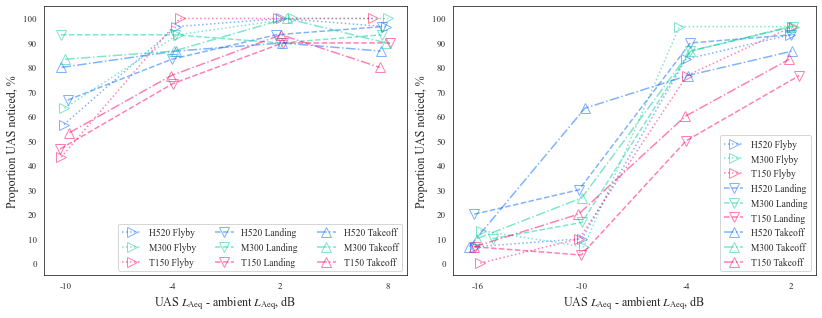

In [495]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 4.5))
fig.subplots_adjust(wspace=1)

# prepare data subset
data = dataByStimTestANotice.loc[dataByStimTestANotice.index.str.find("PwrScale")
                                 == -1, ['AmbientEnv', 'UASType', 'UASOperation', 'SNRlevel', 'NoticedPropFilt']]
data['UASTypeOp'] = data['UASType'].astype(str) + " " + data['UASOperation'].astype(str)
data.loc[data['UASTypeOp'] == "No UAS No UAS", 'UASTypeOp'] = "No UAS"
UASTypeOpCats = ["No UAS", "H520 Flyby", "M300 Flyby", "T150 Flyby", "H520 Landing", "M300 Landing", "T150 Landing",
                 "H520 Takeoff", "M300 Takeoff", "T150 Takeoff"]
data['UASTypeOp'] = pd.Categorical(data['UASTypeOp'], UASTypeOpCats)
data = data.sort_values(by=['UASTypeOp', 'AmbientEnv', 'SNRlevel']).iloc[2:]

markers = {'Flyby': '>', 'Landing': 'v', 'Takeoff': '^'}
lines = {'Flyby': ':', 'Landing': '--', 'Takeoff': '-.'}
colours = {'H520': mycolours[0], 'M300': mycolours[1], 'T150': mycolours[2]}
xjitter = 0.03

# loop over ambient env and each type-operation combination to plot
for iiEnv, ambEnv in enumerate(data['AmbientEnv'].unique()):
    ax = axs[iiEnv]
    for jjTypeOp, typeOp in enumerate(UASTypeOpCats[1:]):
        subdata = data.loc[(data['AmbientEnv'] == ambEnv)
                            & (data['UASTypeOp'] == typeOp), :]
        marker = markers[subdata['UASOperation'].iloc[0]]
        line = lines[subdata['UASOperation'].iloc[0]]
        colour = colours[subdata['UASType'].iloc[0]]

        x_jitter = stats.t(df=6, scale=xjitter).rvs(4)
        ax.plot(range(1, 5) + x_jitter, subdata['NoticedPropFilt'], linestyle=line, marker=marker,
                color=colour, alpha=0.5, label=subdata['UASTypeOp'].iloc[0], 
                markerfacecolor='none', markersize=10)

    ax.set(xticks=range(1, 5), xticklabels=subdata['SNRlevel'],
           xlabel="UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
           yticks=np.arange(0, 1.1, 0.1), yticklabels=range(0, 110, 10),
           ylabel="Proportion UAS noticed, %", ylim=[-0.05, 1.05])
    if ambEnv == "Park":
        ncol = 3
    else:
        ncol = 1
    ax.legend(fontsize=9.5, ncol=ncol, loc='lower right')

if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsSNRByAmbTypeOpFilt.svg"),
                format='svg')
plt.show()

### Association analysis
#### Aggregated responses

Correlations are examined using the aggregated responses. This is because the correlation analysis assumes independency of errors, which is not met by a within-subjects design. This violation can be addressed using the aggregated responses.

The analysis is undertaken for the whole dataset, as well as segregrating by UAS type and flight operation.

In [107]:
# reduce dataset for response analysis
includecols = ["LAeqMaxLR", "LAFmaxMaxLR", "LAF5ExMaxLR", "LAF10ExMaxLR",
               "LAF25ExMaxLR", "LAF50ExMaxLR",
               "LAF75ExMaxLR", "LAF90ExMaxLR", "LAF95ExMaxLR", "LASmaxMaxLR",
               "EPNLMaxLR", "EPNLNoTMaxLR", "PNLTmaxMaxLR",
               "LoudECMAHMSPowAvgBin", "LoudISO105ExMaxLR", "LoudISO1PowAvgMaxLR",
               "LoudISO3PowAvgBin", "TonalECMAHMSAvgMaxLR", "TonalECMAHMS05ExMaxLR",
               "TonalIntAvgMaxLR", "TonalInt05ExMaxLR", "TonLdECMAHMSPowAvgBin",
                "TonLdECMAHMS05ExBin", "TonalAuAvgMaxLR", "TonalAu10ExMaxLR",
               "TonalAu05ExMaxLR", "RoughECMAHMS10ExBin", "RoughECMAHMS05ExBin",
               "RoughFZ10ExMaxLR", "RoughFZ05ExMaxLR", "RoughDW10ExMaxLR", "RoughDW05ExMaxLR",
               "FluctHMS10ExBin", "FluctHMS05ExBin", "FluctFZ10ExMaxLR", "FluctFZ05ExMaxLR",
               "FluctOV10ExMaxLR", "FluctOV05ExMaxLR",
               "SharpAuresISO3PowAvgMaxLR", "SharpAuresISO305ExMaxLR",
               "ImpulsHMSPowAvgMaxLR", "ImpulsHMSAvgMaxLR", "ImpulsHMS05ExMaxLR"]
includecols = (includecols +
               ["UAS" + includecol for includecol in includecols]
               + ["Amb" + includecol for includecol in includecols])
includecols = includecols + ["SNRlevel", "LAeqdiffLAF90",
                             "LASmaxdiffLAF90", "LASmaxdiffLAF50",
                             "LASmaxdiffLAeq", "PartLoudGMSTPowAvg", 
                             "PartLoudGMLTPowAvg", "PartLoudGMST05Ex", 
                             "PartLoudGMLT05Ex",
                             "PNLMLAeqdiff", "PNLTMLAeqdiff", "EPNLLAeqdiff",
                             "PNLMLAF90diff", "PNLTMLAF90diff", "EPNLLAF90diff",
                             "PNLMLAF50diff", "PNLTMLAF50diff", "EPNLLAF50diff"]
includecols = includecols + ["dTonalECMAHMSAvgMaxLR", "dTonalECMAHMS05ExMaxLR",
                             "dTonalIntAvgMaxLR", "dTonalInt05ExMaxLR", "dTonLdECMAHMSPowAvgBin",
                             "dTonLdECMAHMS05ExBin"
                             "dRoughECMAHMS10ExBin", "dRoughECMAHMS05ExBin",
                             "dFluctHMS10ExBin", "dFluctHMS05ExBin",
                             "dSharpAuresISO3PowAvgMaxLR", "dSharpAuresISO305ExMaxLR",
                             "dImpulsHMSPowAvgMaxLR", "dImpulsHMSAvgMaxLR", "dImpulsHMS05ExMaxLR"]
includecols = (["AnnoyMedian", "AnnoyMean", "ValenceMedian", "ValenceMean",
                "ArousalMedian", "ArousalMean", "dAnnoyMedian", "dAnnoyMean", "dValenceMedian", "dValenceMean",
                "dArousalMedian", "dArousalMean", "HighAnnoyProportion"]
               + includecols)


In [108]:
# reduced dataset
ptADataForCorr = dataByStimTestA.loc[:, includecols]
# segregated by UAS type and operation
UASTypes = dataByStimTestA['UASType'].unique()[1:]
ptADataForCorrByUAS = [dataTemp for dataTemp in
                       [dataByStimTestA.loc[dataByStimTestA['UASType'] == UAS,
                                            includecols] for UAS
                        in UASTypes]]
# segregated by operation
UASOps = dataByStimTestA['UASOperation'].unique()[1:]
ptADataForCorrByOp = [dataTemp for dataTemp in
                      [dataByStimTestA.loc[dataByStimTestA['UASOperation']
                                           == Op, includecols] for Op
                       in UASOps]]
# segregated by UAS type and operation
ptADataForCorrByUASByOp = list()
count = 0
for UAS in UASTypes:
    for Op in UASOps:
        ptADataForCorrByUASByOp.append(dataByStimTestA.loc[np.logical_and(dataByStimTestA['UASType']
                                                                          == UAS,
                                                                          dataByStimTestA['UASOperation']
                                                                          == Op),
                                                           includecols])


In [109]:
# prepare data for correlation analysis
ptADataForCorr = dataByStimTestA.loc[:, includecols]
ptADataForCorr['SNRlevel'] = dataByStimTestA['SNRlevel'].cat.codes.astype(float)
ptADataForCorr.loc[ptADataForCorr['SNRlevel'] == -1, 'SNRlevel'] = np.nan

UASTypes = dataByStimTestA['UASType'].unique()[1:]
ptADataForCorrByUAS = [dataTemp for dataTemp in
                       [dataByStimTestA.loc[dataByStimTestA['UASType'] == UAS,
                                            includecols] for UAS
                        in UASTypes]]
for ii, UAS in enumerate(UASTypes):
    ptADataForCorrByUAS[ii]['SNRlevel'] = dataByStimTestA.loc[dataByStimTestA['UASType']
                                                              == UAS,
                                                              'SNRlevel'].cat.codes.astype(float)
    ptADataForCorrByUAS[ii].loc[ptADataForCorrByUAS[ii]['SNRlevel'] == -1, 'SNRlevel'] = np.nan

UASOps = dataByStimTestA['UASOperation'].unique()[1:]
ptADataForCorrByOp = [dataTemp for dataTemp in
                      [dataByStimTestA.loc[dataByStimTestA['UASOperation']
                                           == Op, includecols] for Op
                       in UASOps]]
for ii, Op in enumerate(UASOps):
    ptADataForCorrByOp[ii]['SNRlevel'] = dataByStimTestA.loc[dataByStimTestA['UASOperation']
                                                             == Op,
                                                             'SNRlevel'].cat.codes.astype(float)
    ptADataForCorrByOp[ii].loc[ptADataForCorrByOp[ii]['SNRlevel'] == -1, 'SNRlevel'] = np.nan

AmbEnvs = np.sort(dataByStimTestA['AmbientEnv'].unique())
ptADataForCorrByAmb = [dataTemp for dataTemp in [dataByStimTestA.loc[dataByStimTestA['AmbientEnv']
                                                                     == Env, includecols] for Env
                                                 in AmbEnvs]]
for ii, Env in enumerate(AmbEnvs):
    ptADataForCorrByAmb[ii]['SNRlevel'] = dataByStimTestA.loc[dataByStimTestA['AmbientEnv']
                                                              == Env,
                                                              'SNRlevel'].cat.codes.astype(float)
    ptADataForCorrByAmb[ii].loc[ptADataForCorrByAmb[ii]['SNRlevel'] == -1, 'SNRlevel'] = np.nan

    ptADataForCorrByAmb[ii].drop(ptADataForCorrByAmb[ii].columns[ptADataForCorrByAmb[ii].columns.str.contains('Amb')], axis=1, inplace=True)

In [110]:
# run correlation analysis
corr_matrixA = [ptADataForCorr.corr(method=corr_method, numeric_only=False)
                for corr_method in ['pearson', 'spearman', 'kendall']]
corr_matrixAByUAS = [[dataByUAS.corr(method=corr_method,
                                     numeric_only=False)
                      for corr_method in ['pearson', 'spearman', 'kendall']]
                     for dataByUAS in ptADataForCorrByUAS]
corr_matrixAByOp = [[dataByOp.corr(method=corr_method,
                                   numeric_only=False)
                     for corr_method in ['pearson', 'spearman', 'kendall']]
                    for dataByOp in ptADataForCorrByOp]
corr_matrixAByUASByOp = [[dataByUASByOp.corr(method=corr_method,
                                             numeric_only=False)
                          for corr_method in ['pearson', 'spearman',
                                              'kendall']]
                         for dataByUASByOp in ptADataForCorrByUASByOp]

In [111]:
# re-run correlation analysis using scipy stats to get p-values for main matrix
corr_listA_pr = pd.DataFrame()
corr_listA_sp = pd.DataFrame()
corr_listA_kd = pd.DataFrame()
feat1s = [None]*len(ptADataForCorr.columns)**2
feat2s = [None]*len(ptADataForCorr.columns)**2
corrs_pr = np.zeros(len(ptADataForCorr.columns)**2)
corrs_sp = np.zeros(len(ptADataForCorr.columns)**2)
corrs_kd = np.zeros(len(ptADataForCorr.columns)**2)
pvalues_pr = np.zeros(len(ptADataForCorr.columns)**2)
pvalues_sp = np.zeros(len(ptADataForCorr.columns)**2)
pvalues_kd = np.zeros(len(ptADataForCorr.columns)**2)

count = 0
for feat1 in ptADataForCorr.columns:
    for feat2 in ptADataForCorr.columns:
        if feat1 == feat2:
            corr_pr, pvalue_pr = 1, 0
            corr_kd, pvalue_kd = 1, 0
        else:
            # avoid nan issues and speed up Kendall's tau
            mask = ~np.logical_or(ptADataForCorr[feat1].isna(),
                                  ptADataForCorr[feat2].isna())

            corr_pr, pvalue_pr = stats.pearsonr(ptADataForCorr.loc[mask,
                                                                   feat1].astype(float),
                                                ptADataForCorr.loc[mask,
                                                                   feat2].astype(float))
            corr_kd, pvalue_kd = stats.kendalltau(ptADataForCorr.loc[mask,
                                                                     feat1].astype(float),
                                                  ptADataForCorr.loc[mask,
                                                                     feat2].astype(float))
        corr_sp, pvalue_sp = stats.spearmanr(ptADataForCorr[feat1].astype(float),
                                             ptADataForCorr[feat2].astype(float),
                                             nan_policy='omit')

        feat1s[count] = feat1
        feat2s[count] = feat2
        corrs_pr[count] = corr_pr
        pvalues_pr[count] = pvalue_pr
        corrs_sp[count] = corr_sp
        pvalues_sp[count] = pvalue_sp
        corrs_kd[count] = corr_kd
        pvalues_kd[count] = pvalue_kd

        count += 1

# end of for loop for correlation analysis

corr_listA_pr['Variable_1'] = feat1s
corr_listA_pr['Variable_2'] = feat2s
corr_listA_pr['Correlation'] = corrs_pr
corr_listA_pr['p_value'] = pvalues_pr

corr_listA_sp['Variable_1'] = feat1s
corr_listA_sp['Variable_2'] = feat2s
corr_listA_sp['Correlation'] = corrs_sp
corr_listA_sp['p_value'] = pvalues_sp

corr_listA_kd['Variable_1'] = feat1s
corr_listA_kd['Variable_2'] = feat2s
corr_listA_kd['Correlation'] = corrs_kd
corr_listA_kd['p_value'] = pvalues_kd

corr_matrixA_p = [corrlist.pivot(columns='Variable_2',
                                 index='Variable_1',
                                 values='p_value')[corr_matrixA[1].columns].reindex(corr_matrixA[1].index)
                  for corrlist in [corr_listA_pr,
                                   corr_listA_sp,
                                   corr_listA_kd]]

This is the correlation analysis with the reduced dataset for noticeability analysis

In [112]:
# reduce dataset for noticeablity analysis
includecols = ["LAeqMaxLR", "LAFmaxMaxLR", "LAF5ExMaxLR", "LAF10ExMaxLR",
               "LAF25ExMaxLR", "LAF50ExMaxLR",
               "LAF75ExMaxLR", "LAF90ExMaxLR", "LAF95ExMaxLR", "LASmaxMaxLR",
               "EPNLMaxLR", "EPNLNoTMaxLR", "PNLTmaxMaxLR",
               "LoudECMAHMSPowAvgBin", "LoudISO105ExMaxLR", "LoudISO1PowAvgMaxLR",
               "LoudISO3PowAvgBin", "TonalECMAHMSAvgMaxLR", "TonalECMAHMS05ExMaxLR",
               "TonalIntAvgMaxLR", "TonalInt05ExMaxLR", "TonLdECMAHMSPowAvgBin",
                "TonLdECMAHMS05ExBin", "TonalAuAvgMaxLR", "TonalAu10ExMaxLR",
               "TonalAu05ExMaxLR", "RoughECMAHMS10ExBin", "RoughECMAHMS05ExBin",
               "RoughFZ10ExMaxLR", "RoughFZ05ExMaxLR", "RoughDW10ExMaxLR", "RoughDW05ExMaxLR",
               "FluctHMS10ExBin", "FluctHMS05ExBin", "FluctFZ10ExMaxLR", "FluctFZ05ExMaxLR",
               "FluctOV10ExMaxLR", "FluctOV05ExMaxLR",
               "SharpAuresISO3PowAvgMaxLR", "SharpAuresISO305ExMaxLR",
               "ImpulsHMSPowAvgMaxLR", "ImpulsHMSAvgMaxLR", "ImpulsHMS05ExMaxLR"]
includecols = (includecols +
               ["UAS" + includecol for includecol in includecols]
               + ["Amb" + includecol for includecol in includecols])
includecols = includecols + ["SNRlevel", "LAeqdiffLAF90",
                             "LASmaxdiffLAF90", "LASmaxdiffLAF50",
                             "LASmaxdiffLAeq", "PartLoudGMSTPowAvg", 
                             "PartLoudGMLTPowAvg", "PartLoudGMST05Ex", 
                             "PartLoudGMLT05Ex",
                             "PNLMLAeqdiff", "PNLTMLAeqdiff", "EPNLLAeqdiff",
                             "PNLMLAF90diff", "PNLTMLAF90diff", "EPNLLAF90diff",
                             "PNLMLAF50diff", "PNLTMLAF50diff", "EPNLLAF50diff"]
includecols = includecols + ["dTonalECMAHMSAvgMaxLR", "dTonalECMAHMS05ExMaxLR",
                             "dTonalIntAvgMaxLR", "dTonalInt05ExMaxLR", "dTonLdECMAHMSPowAvgBin",
                             "dTonLdECMAHMS05ExBin"
                             "dRoughECMAHMS10ExBin", "dRoughECMAHMS05ExBin",
                             "dFluctHMS10ExBin", "dFluctHMS05ExBin",
                             "dSharpAuresISO3PowAvgMaxLR", "dSharpAuresISO305ExMaxLR",
                             "dImpulsHMSPowAvgMaxLR", "dImpulsHMSAvgMaxLR", "dImpulsHMS05ExMaxLR"]
includecols = (["AnnoyMedianFilt", "AnnoyMeanFilt", "ValenceMedianFilt", "ValenceMeanFilt",
                "ArousalMedianFilt", "ArousalMeanFilt", "dAnnoyMedianFilt", "dAnnoyMeanFilt",
                "dValenceMedianFilt", "dValenceMeanFilt", "dArousalMedianFilt", "dArousalMeanFilt",
                "HighAnnoyPropFilt", "NoticedPropFilt"]
               + includecols)


In [113]:
# prepare data for correlation analysis
ptANoticeDataForCorr = dataByStimTestANotice.loc[:, includecols]
ptANoticeDataForCorr['SNRlevel'] = dataByStimTestANotice['SNRlevel'].cat.codes.astype(float)
ptANoticeDataForCorr.loc[ptANoticeDataForCorr['SNRlevel'] == -1, 'SNRlevel'] = np.nan

UASTypes = dataByStimTestANotice['UASType'].unique()[1:]
ptANoticeDataForCorrByUAS = [dataTemp for dataTemp in
                             [dataByStimTestANotice.loc[dataByStimTestANotice['UASType'] == UAS,
                                                        includecols] for UAS
                              in UASTypes]]
for ii, UAS in enumerate(UASTypes):
    ptANoticeDataForCorrByUAS[ii]['SNRlevel'] = dataByStimTestANotice.loc[dataByStimTestANotice['UASType']
                                                                          == UAS,
                                                                          'SNRlevel'].cat.codes.astype(float)
    ptANoticeDataForCorrByUAS[ii].loc[ptANoticeDataForCorrByUAS[ii]['SNRlevel'] == -1, 'SNRlevel'] = np.nan

UASOps = dataByStimTestANotice['UASOperation'].unique()[1:]
ptANoticeDataForCorrByOp = [dataTemp for dataTemp in
                            [dataByStimTestANotice.loc[dataByStimTestANotice['UASOperation']
                                                       == Op, includecols] for Op
                             in UASOps]]
for ii, Op in enumerate(UASOps):
    ptANoticeDataForCorrByOp[ii]['SNRlevel'] = dataByStimTestANotice.loc[dataByStimTestANotice['UASOperation']
                                                                         == Op,
                                                                         'SNRlevel'].cat.codes.astype(float)
    ptANoticeDataForCorrByOp[ii].loc[ptANoticeDataForCorrByOp[ii]['SNRlevel'] == -1, 'SNRlevel'] = np.nan

#ptANoticeDataForCorrByUASByOp = list()
#count = 0
#for UAS in UASTypes:
#    for Op in UASOps:
#        ptANoticeDataForCorrByUASByOp.append(dataByStimTestANotice.loc[np.logical_and(dataByStimTestANotice['UASType']
#                                                                                 == UAS,
#                                                                                 dataByStimTestANotice['UASOperation']
#                                                                                 == Op),
#                                                                       includecols])

AmbEnvs = np.sort(dataByStimTestANotice['AmbientEnv'].unique())
ptANoticeDataForCorrByAmb = [dataTemp for dataTemp in [dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']
                                                       == Env, includecols] for Env
                             in AmbEnvs]]
for ii, Env in enumerate(AmbEnvs):
    ptANoticeDataForCorrByAmb[ii]['SNRlevel'] = dataByStimTestANotice.loc[dataByStimTestANotice['AmbientEnv']
                                                                          == Env,
                                                                          'SNRlevel'].cat.codes.astype(float)
    ptANoticeDataForCorrByAmb[ii].loc[ptANoticeDataForCorrByAmb[ii]['SNRlevel'] == -1, 'SNRlevel'] = np.nan

    ptANoticeDataForCorrByAmb[ii].drop(ptANoticeDataForCorrByAmb[ii].columns[ptANoticeDataForCorrByAmb[ii].columns.str.contains('Amb')], axis=1, inplace=True)

In [114]:
# run correlation analysis
corr_matrixANotice = [ptANoticeDataForCorr.corr(method=corr_method, numeric_only=False)
                      for corr_method in ['pearson', 'spearman', 'kendall']]
corr_matrixANoticeByUAS = [[dataByUAS.corr(method=corr_method,
                                           numeric_only=False)
                            for corr_method in ['pearson', 'spearman', 'kendall']]
                           for dataByUAS in ptANoticeDataForCorrByUAS]
corr_matrixANoticeByOp = [[dataByOp.corr(method=corr_method,
                                   numeric_only=False)
                     for corr_method in ['pearson', 'spearman', 'kendall']]
                    for dataByOp in ptANoticeDataForCorrByOp]
corr_matrixANoticeByAmb = [[dataByAmb.corr(method=corr_method,
                                   numeric_only=False)
                     for corr_method in ['pearson', 'spearman', 'kendall']]
                    for dataByAmb in ptANoticeDataForCorrByAmb]

In [115]:
# re-run correlation analysis to get p-values for main matrix
corr_listA_pr = pd.DataFrame()
corr_listA_sp = pd.DataFrame()
corr_listA_kd = pd.DataFrame()
feat1s = [None]*len(ptANoticeDataForCorr.columns)**2
feat2s = [None]*len(ptANoticeDataForCorr.columns)**2
corrs_pr = np.zeros(len(ptANoticeDataForCorr.columns)**2)
corrs_sp = np.zeros(len(ptANoticeDataForCorr.columns)**2)
corrs_kd = np.zeros(len(ptANoticeDataForCorr.columns)**2)
pvalues_pr = np.zeros(len(ptANoticeDataForCorr.columns)**2)
pvalues_sp = np.zeros(len(ptANoticeDataForCorr.columns)**2)
pvalues_kd = np.zeros(len(ptANoticeDataForCorr.columns)**2)

count = 0
for feat1 in ptANoticeDataForCorr.columns:
    for feat2 in ptANoticeDataForCorr.columns:
        if feat1 == feat2:
            corr_pr, pvalue_pr = 1, 0
            corr_kd, pvalue_kd = 1, 0
        else:
            # avoid nan issues and speed up Kendall's tau
            mask = ~np.logical_or(ptANoticeDataForCorr[feat1].isna(),
                                  ptANoticeDataForCorr[feat2].isna())

            corr_pr, pvalue_pr = stats.pearsonr(ptANoticeDataForCorr.loc[mask,
                                                                   feat1].astype(float),
                                                ptANoticeDataForCorr.loc[mask,
                                                                   feat2].astype(float))
            corr_kd, pvalue_kd = stats.kendalltau(ptANoticeDataForCorr.loc[mask,
                                                                     feat1].astype(float),
                                                  ptANoticeDataForCorr.loc[mask,
                                                                     feat2].astype(float))
        corr_sp, pvalue_sp = stats.spearmanr(ptANoticeDataForCorr[feat1].astype(float),
                                             ptANoticeDataForCorr[feat2].astype(float),
                                             nan_policy='omit')

        feat1s[count] = feat1
        feat2s[count] = feat2
        corrs_pr[count] = corr_pr
        pvalues_pr[count] = pvalue_pr
        corrs_sp[count] = corr_sp
        pvalues_sp[count] = pvalue_sp
        corrs_kd[count] = corr_kd
        pvalues_kd[count] = pvalue_kd

        count += 1

# end of for loop for correlation analysis

corr_listA_pr['Variable_1'] = feat1s
corr_listA_pr['Variable_2'] = feat2s
corr_listA_pr['Correlation'] = corrs_pr
corr_listA_pr['p_value'] = pvalues_pr

corr_listA_sp['Variable_1'] = feat1s
corr_listA_sp['Variable_2'] = feat2s
corr_listA_sp['Correlation'] = corrs_sp
corr_listA_sp['p_value'] = pvalues_sp

corr_listA_kd['Variable_1'] = feat1s
corr_listA_kd['Variable_2'] = feat2s
corr_listA_kd['Correlation'] = corrs_kd
corr_listA_kd['p_value'] = pvalues_kd

corr_matrixANotice_p = [corrlist.pivot(columns='Variable_2',
                                       index='Variable_1',
                                       values='p_value')[corr_matrixANotice[1].columns].reindex(corr_matrixANotice[1].index)
                        for corrlist in [corr_listA_pr,
                                         corr_listA_sp,
                                         corr_listA_kd]]


##### Noticeability correlations

In [122]:
# level or loudness difference metrics
indicesDiff = ['SNRlevel', 'LAeqdiffLAF90',
               'LASmaxdiffLAF90', 'LASmaxdiffLAF50',
               'LASmaxdiffLAeq', 'PartLoudGMSTPowAvg', 
               'PartLoudGMLTPowAvg', 'PartLoudGMST05Ex', 
               'PartLoudGMLT05Ex',
               'PNLMLAeqdiff', 'PNLTMLAeqdiff', 'EPNLLAeqdiff',
               'PNLMLAF90diff', 'PNLTMLAF90diff', 'EPNLLAF90diff',
               'PNLMLAF50diff', 'PNLTMLAF50diff', 'EPNLLAF50diff']

labelsDiff = ["UAS $L_\\text{Aeq}$ - ambient $L_\\text{Aeq}$, dB",
              "UAS $L_\\text{Aeq}$ - ambient $L_\\text{AF90}$, dB",
              "UAS $L_\\text{ASmax}$ - ambient $L_\\text{AF90}$, dB",
              "UAS $L_\\text{ASmax}$ - ambient $L_\\text{AF50}$, dB",
              "UAS $L_\\text{ASmax}$ - ambient $L_\\text{Aeq}$, dB",
              "LT M-G part. loudness (pow avg), sones",
              "LT M-G part. loudness (5% exc), sones",
              "ST M-G part. loudness (pow avg), sones",
              "ST M-G part. loudness (5% exc), sones",
              "UAS PNLM - ambient $L_\\text{Aeq}$, dB",
              "UAS PNLTM - ambient $L_\\text{Aeq}$, dB",
              "UAS EPNL - ambient $L_\\text{Aeq}$, dB"
              "UAS PNLM - ambient $L_\\text{AF90}$, dB",
              "UAS PNLTM - ambient $L_\\text{AF90}$, dB",
              "UAS EPNL - ambient $L_\\text{AF90}$, dB",
              "UAS PNLM - ambient $L_\\text{AF50}$, dB",
              "UAS PNLTM - ambient $L_\\text{AF50}$, dB",
              "UAS EPNL - ambient $L_\\text{AF50}$, dB"]


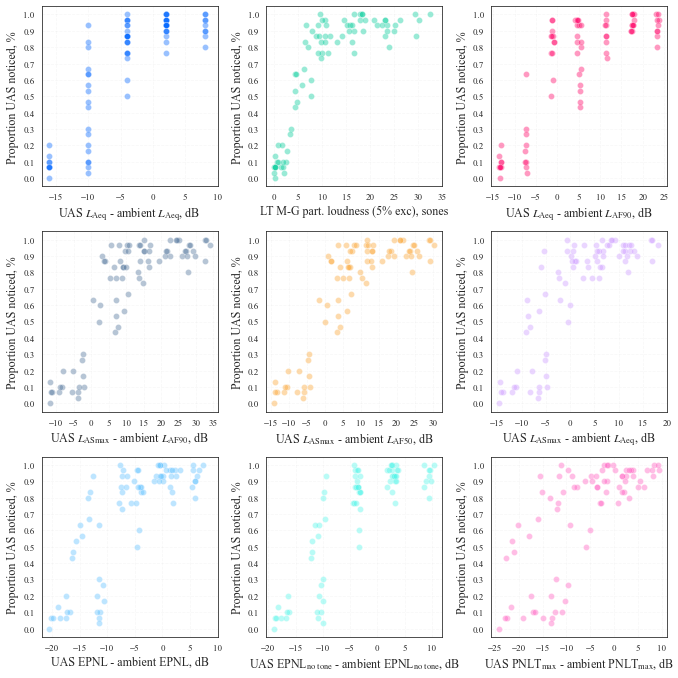

In [123]:

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(9.5, 19))
dictSNR = {0: "No UAS", 1: -16, 2: -10, 3: -4, 4: 2, 5: 8}
data = ptANoticeDataForCorr.copy()
data['SNRlevel'] = data['SNRlevel'].map(dictSNR)
for ii, (index, ax) in enumerate(zip(indicesDiff, axs.ravel())):
    if ii > len(indicesDiff):
        pass
    else:
        sns.scatterplot(data=pd.to_numeric(data[index], errors='coerce').to_frame().join(data['NoticedPropFilt']),
                        x=index, y='NoticedPropFilt',
                        ax=ax, color=mycolours[ii], alpha=0.4)
        ax.set(xticks=range(int((np.min(pd.to_numeric(data[index], errors='coerce').to_frame())-2)/5)*5,
                            round(np.ceil(np.max(pd.to_numeric(data[index], errors='coerce').to_frame()))/5)*5 + 5,
                            5), yticks=np.arange(0, 1.1, 0.1),
               xlabel=labelsDiff[ii],
               ylabel="Proportion UAS noticed, %")
        ax.grid(alpha=0.15, linestyle='--')
plt.show()


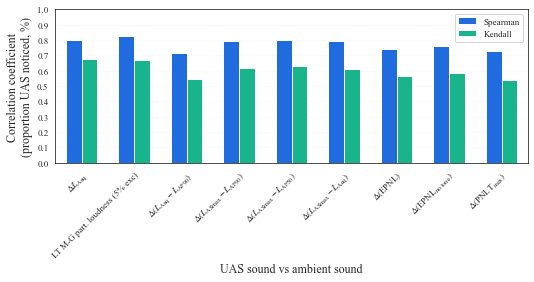

In [124]:
fig, ax = plt.subplots(figsize=(16, 4))
data = pd.DataFrame(data=[corr_matrixANotice[1].loc['NoticedPropFilt',
                                              indicesDiff],
                          corr_matrixANotice[2].loc['NoticedPropFilt',
                                              indicesDiff]],
                    index=["Spearman", "Kendall"])
sns.barplot(data=data.melt(var_name="Type",
                           ignore_index=False).reset_index(names="Method"),
            x='Type', y='value', hue='Method', width=0.6,
            palette=mycolours[0:2], ax=ax)
labelsDiffShort = ["$\\Delta L_\\text{Aeq}$",
                   "$\\Delta(L_\\text{Aeq}-L_\\text{AF90})$",
                   "$\\Delta(L_\\text{ASmax}-L_\\text{AF90})$",
                   "$\\Delta(L_\\text{ASmax}-L_\\text{AF50})$",
                   "$\\Delta(L_\\text{ASmax}-L_\\text{Aeq})$",
                   "LT M-G part. loudness (pow avg)",
                   "LT M-G part. loudness (5% exc)",
                   "ST M-G part. loudness (pow avg)",
                   "ST M-G part. loudness (5% exc)",
                   "PNLM $- L_\\text{Aeq}$",
                   "PNLTM $- L_\\text{Aeq}$",
                   "EPNL $- L_\\text{Aeq}$"
                   "PNLM $- L_\\text{AF90}$",
                   "PNLTM $- ambient $L_\\text{AF90}$",
                   "EPNL $- L_\\text{AF90}$",
                   "PNLM $- L_\\text{AF50}$",
                   "PNLTM $- L_\\text{AF50}$",
                   "EPNL $- L_\\text{AF50}$"]
ax.set(yticks=np.arange(0, 1.1, 0.1), xlabel="UAS sound vs ambient sound",
       ylabel="Correlation coefficient" + "\n" + "(proportion UAS noticed, %)")
ax.set_xticks(ticks=range(len(labelsDiffShort)), labels=labelsDiffShort,
              rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='best')
ax.grid(alpha=0.15, linestyle='--', axis='y')
plt.show()

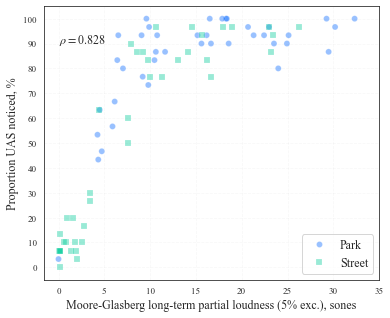

In [125]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))
data = dataByStimTestANotice.sort_values(by='AmbientEnv')
markers = {"Park": 'o', "Street": "s"}
sns.scatterplot(data=data, x='PartLoudGMLT05Ex', y='NoticedPropFilt',
                hue='AmbientEnv', markers=markers, style='AmbientEnv',
                ax=ax, palette=mycolours[0:2], alpha=0.4)
ax.set(xticks=range(int((np.min(dataByStimTestANotice['PartLoudGMLT05Ex'])-1)/5)*5,
                    round(np.ceil(np.max(dataByStimTestANotice['PartLoudGMLT05Ex']))/5)*5 + 5,
                    5), yticks=np.arange(0, 1.1, 0.1), yticklabels=range(0, 110, 10),
       xlabel="Moore-Glasberg long-term partial loudness (5% exc.), sones",
       ylabel="Proportion UAS noticed, %")
ax.grid(alpha=0.15, linestyle='--')
ax.legend(loc='lower right', fontsize=12)
ax.text(x=0, y=0.9, s=r"$\rho=$" + str(np.round(corr_matrixANotice[1].loc['NoticedPropFilt', 'PartLoudGMLT05Ex'], 3)),
        fontsize=12)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsPartLoudByAmbFilt.svg"),
                format='svg')
plt.show()

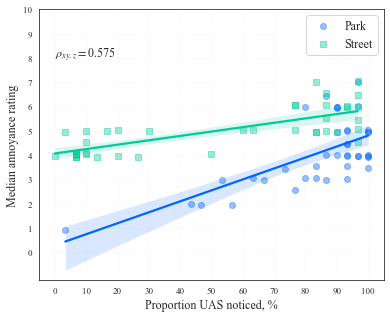

In [345]:
# correlation notice vs median annoyance
fig, ax = plt.subplots(figsize=(5.5, 4.5))
data = dataByStimTestANotice.loc[:, ['AmbientEnv', 'AmbientLAeq', 'NoticedPropFilt',
                               'AnnoyMedianFilt']].sort_values(by='AmbientEnv')
sns.regplot(data=data.loc[data['AmbientEnv'] == "Park"],
            x='NoticedPropFilt', y='AnnoyMedianFilt', label="Park",
            color=mycolours[0], fit_reg=True, n_boot=5000, scatter=True, marker='o',
            scatter_kws=dict(alpha=0.4), y_jitter=0.075, ax=ax)
sns.regplot(data=data.loc[data['AmbientEnv'] == "Street"],
            x='NoticedPropFilt', y='AnnoyMedianFilt', label="Street",
            color=mycolours[1], fit_reg=True,  n_boot=5000, scatter=True, marker='s',
            scatter_kws=dict(alpha=0.4), y_jitter=0.075, ax=ax)
ax.set(xticks=np.arange(0, 1.1, 0.1), xticklabels=range(0, 110, 10),
       xlim=[-0.05, 1.05], xlabel="Proportion UAS noticed, %",
       yticks=range(0, 11), ylabel="Median annoyance rating")
ax.grid(alpha=0.15, linestyle='--')
ax.legend(loc='best', fontsize=12)
partial_rho = pg.partial_corr(data=data, x='NoticedPropFilt', y='AnnoyMedianFilt',
                              covar='AmbientLAeq', method='spearman')
ax.text(x=0, y=8, s=r"$\rho_{xy.z} = $" + str(np.round(partial_rho['r'].iloc[0], 3)), fontsize=12)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsAnnoyByAmbFilt.svg"),
                format='svg')
plt.show()


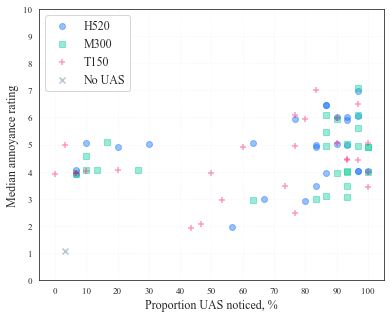

In [138]:
# correlation notice vs median annoyance
fig, ax = plt.subplots(figsize=(5.5, 4.5))
data = dataByStimTestANotice.loc[:, ['UASType', 'NoticedPropFilt',
                                     'AnnoyMedianFilt']].sort_values(by='UASType')
sns.regplot(data=data.loc[data['UASType'] == "H520"],
            x='NoticedPropFilt', y='AnnoyMedianFilt',
            color=mycolours[0], fit_reg=False, scatter=True, marker='o',
            scatter_kws=dict(alpha=0.4), y_jitter=0.1, ax=ax)
sns.regplot(data=data.loc[data['UASType'] == "M300"],
            x='NoticedPropFilt', y='AnnoyMedianFilt',
            color=mycolours[1], fit_reg=False, scatter=True, marker='s',
            scatter_kws=dict(alpha=0.4), y_jitter=0.1, ax=ax)
sns.regplot(data=data.loc[data['UASType'] == "T150"],
            x='NoticedPropFilt', y='AnnoyMedianFilt',
            color=mycolours[2], fit_reg=False, scatter=True, marker='+',
            scatter_kws=dict(alpha=0.4), y_jitter=0.1, ax=ax)
sns.regplot(data=data.loc[data['UASType'] == "No UAS"],
            x='NoticedPropFilt', y='AnnoyMedianFilt',
            color=mycolours[3], fit_reg=False, scatter=True, marker='x',
            scatter_kws=dict(alpha=0.4), y_jitter=0.1, ax=ax)
ax.set(xticks=np.arange(0, 1.1, 0.1), xticklabels=range(0, 110, 10),
       xlim=[-0.05, 1.05], xlabel="Proportion UAS noticed, %",
       yticks=range(0, 11), ylabel="Median annoyance rating")
ax.grid(alpha=0.15, linestyle='--')
ax.legend(labels=["H520", "M300", "T150", "No UAS"], loc='best', fontsize=12)
#ax.text(x=0, y=8, s=r"All $\rho=$" + str(np.round(corr_matrixANotice[1].loc['NoticedPropFilt', 'AnnoyMedianFilt'], 3))
#        + "\nPark " + r"$\rho=$" + str(np.round(corr_matrixANoticeByAmb[0][1].loc['NoticedPropFilt', 'AnnoyMedianFilt'], 3))
#        + "\nStreet " + r"$\rho=$" + str(np.round(corr_matrixANoticeByAmb[1][1].loc['NoticedPropFilt', 'AnnoyMedianFilt'], 3)),
#       fontsize=12)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsAnnoyByTypeFilt.svg"),
                format='svg')
plt.show()


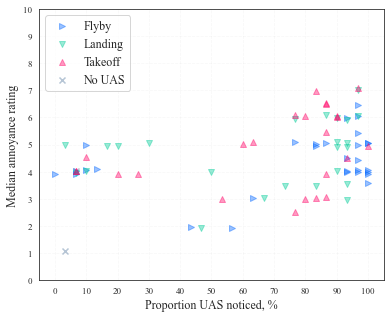

In [213]:
# correlation notice vs median annoyance
fig, ax = plt.subplots(figsize=(5.5, 4.5))
data = dataByStimTestANotice.loc[:, ['UASOperation', 'NoticedPropFilt',
                                     'AnnoyMedianFilt']].sort_values(by='UASOperation')
sns.regplot(data=data.loc[data['UASOperation'] == "Flyby"],
            x='NoticedPropFilt', y='AnnoyMedianFilt',
            color=mycolours[0], fit_reg=False, scatter=True, marker='>',
            scatter_kws=dict(alpha=0.4), y_jitter=0.1, ax=ax)
sns.regplot(data=data.loc[data['UASOperation'] == "Landing"],
            x='NoticedPropFilt', y='AnnoyMedianFilt',
            color=mycolours[1], fit_reg=False, scatter=True, marker='v',
            scatter_kws=dict(alpha=0.4), y_jitter=0.1, ax=ax)
sns.regplot(data=data.loc[data['UASOperation'] == "Takeoff"],
            x='NoticedPropFilt', y='AnnoyMedianFilt',
            color=mycolours[2], fit_reg=False, scatter=True, marker='^',
            scatter_kws=dict(alpha=0.4), y_jitter=0.1, ax=ax)
sns.regplot(data=data.loc[data['UASOperation'] == "No UAS"],
            x='NoticedPropFilt', y='AnnoyMedianFilt',
            color=mycolours[3], fit_reg=False, scatter=True, marker='x',
            scatter_kws=dict(alpha=0.4), y_jitter=0.1, ax=ax)
ax.set(xticks=np.arange(0, 1.1, 0.1), xticklabels=range(0, 110, 10),
       xlim=[-0.05, 1.05], xlabel="Proportion UAS noticed, %",
       yticks=range(0, 11), ylabel="Median annoyance rating")
ax.grid(alpha=0.15, linestyle='--')
ax.legend(labels=["Flyby", "Landing", "Takeoff", "No UAS"], loc='upper left', fontsize=12)
#ax.text(x=0, y=8, s=r"All $\rho=$" + str(np.round(corr_matrixANotice[1].loc['NoticedPropFilt', 'AnnoyMedianFilt'], 3))
#        + "\nPark " + r"$\rho=$" + str(np.round(corr_matrixANoticeByAmb[0][1].loc['NoticedPropFilt', 'AnnoyMedianFilt'], 3))
#        + "\nStreet " + r"$\rho=$" + str(np.round(corr_matrixANoticeByAmb[1][1].loc['NoticedPropFilt', 'AnnoyMedianFilt'], 3)),
#       fontsize=12)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsAnnoyByOpFilt.svg"),
                format='svg')
plt.show()


In [443]:
# prepare subset of data
dataByStimTestANotice['UASTypeOp'] = dataByStimTestANotice['UASType'].astype(str) + " " + dataByStimTestANotice['UASOperation'].astype(str)
dataByStimTestANotice.loc[dataByStimTestANotice['UASTypeOp'] == "No UAS No UAS", 'UASTypeOp'] = "No UAS"
UASTypeOpCats = ["No UAS", "H520 Flyby", "M300 Flyby", "T150 Flyby", "H520 Landing", "M300 Landing", "T150 Landing",
                 "H520 Takeoff", "M300 Takeoff", "T150 Takeoff"]

dataByStimTestANotice['UASTypeOp'] = pd.Categorical(dataByStimTestANotice['UASTypeOp'], UASTypeOpCats)

In [445]:

data = dataByStimTestANotice.loc[:, ['NoticedPropFilt', 'AmbientEnv', 'UASTypeOp', 'UASType',
                                     'UASOperation', 'SNRlevel', 'AnnoyMedianFilt']]
data.sort_values(by=['AmbientEnv', 'UASTypeOp', 'SNRlevel'], inplace=True)


,NoticedPropFilt,AmbientEnv,UASTypeOp,UASType,UASOperation,SNRlevel,AnnoyMedianFilt
A2_CALBIN_Pa.wav,0.033333,Park,No UAS,No UAS,No UAS,No UAS,1.0
A2_H520_F_4_R_CALBIN_Pa.wav,0.566667,Park,H520 Flyby,H520,Flyby,-10,2.0
A2_H520_F_3_L_CALBIN_Pa.wav,0.966667,Park,H520 Flyby,H520,Flyby,-4,4.0
A2_H520_F_2_R_CALBIN_Pa.wav,1.000000,Park,H520 Flyby,H520,Flyby,2,4.0
A2_H520_F_2_R_PwrScale_CALBIN_Pa.wav,0.966667,Park,H520 Flyby,H520,Flyby,2,4.0
A2_H520_F_1_L_CALBIN_Pa.wav,0.966667,Park,H520 Flyby,H520,Flyby,8,6.0
A2_M300_F_4_R_CALBIN_Pa.wav,0.633333,Park,M300 Flyby,M300,Flyby,-10,3.0
A2_M300_F_3_R_CALBIN_Pa.wav,0.933333,Park,M300 Flyby,M300,Flyby,-4,4.0
A2_M300_F_2_L_CALBIN_Pa.wav,1.000000,Park,M300 Flyby,M300,Flyby,2,4.0
A2_M300_F_2_L_PwrScale_CALBIN_Pa.wav,0.933333,Park,M300 Flyby,M300,Flyby,2,4.0


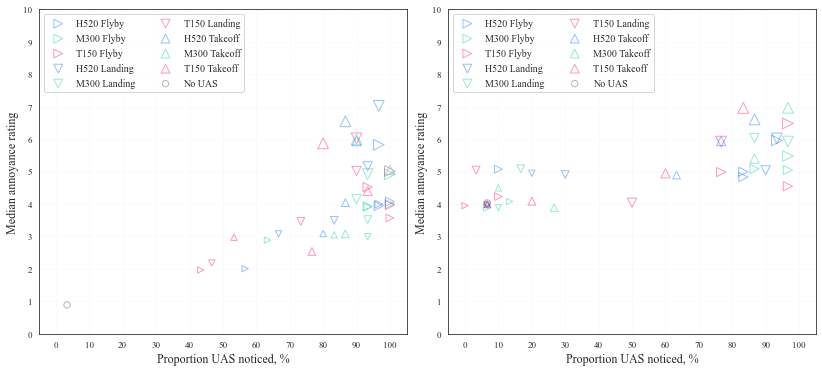

In [470]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 5.25))
fig.subplots_adjust(wspace=1.5)

data = dataByStimTestANotice.loc[:, ['NoticedPropFilt', 'AmbientEnv', 'UASTypeOp', 'UASType',
                                     'UASOperation', 'UASLAeq', 'AnnoyMedianFilt']]
data.sort_values(by=['AmbientEnv', 'UASTypeOp', 'UASLAeq'], inplace=True)

markers = {'No UAS': 'o', 'Flyby': '>', 'Landing': 'v', 'Takeoff': '^'}
colours = {'No UAS': [0.3, 0.3, 0.3], 'H520': mycolours[0], 'M300': mycolours[1], 'T150': mycolours[2]}
sizes = {'No UAS': 40,
         'Flyby': [40, 60, 85, 85, 115],
         'Landing': [40, 60, 85, 115],
         'Takeoff': [40, 60, 85, 115]}

yjitter = 0.07

for jjEnv, ambEnv in enumerate(list(data['AmbientEnv'].sort_values().unique())):
    ax = axs[jjEnv]
    for iiTypeOp, typeOp in enumerate(list(data['UASTypeOp'].unique())[1:]
                                      + [list(data['UASTypeOp'].unique())[0]]):

        subdata = data.loc[(data['UASTypeOp'] == typeOp) & (data['AmbientEnv'] == ambEnv)]
        
        # set marker format
        if typeOp.find("No UAS") != -1:
            colour = [0.3, 0.3, 0.3]
            marker = 'x'
        elif typeOp.find("H520") != -1:
            colour = mycolours[0]
        elif typeOp.find("M300") != -1:
            colour = mycolours[1]
        elif typeOp.find("T150") != -1:
            colour = mycolours[2]

        if typeOp.find("Flyby") != -1:
            marker = '>'
        elif typeOp.find("Landing") != -1:
            marker = 'v'
        elif typeOp.find("Takeoff") != -1:
            marker = '^'
        
        y_jitter = stats.t(df=6, scale=yjitter).rvs(len(subdata['AnnoyMedianFilt']))
        
        ax.scatter(subdata['NoticedPropFilt'],
                   subdata['AnnoyMedianFilt'] + y_jitter,
                   s = sizes[subdata['UASOperation'].iloc[0]],
                   color=colours[subdata['UASType'].iloc[0]],
                   marker=markers[subdata['UASOperation'].iloc[0]],
                   facecolors='none',
                   alpha=0.4, label=typeOp)

    ax.grid(alpha=0.15, linestyle='--')
    ax.set(xticks=np.arange(0, 1.1, 0.1), xticklabels=range(0, 110, 10), xlim=[-0.05, 1.05],
           yticks=range(0, 11, 1),
           xlabel="Proportion UAS noticed, %",
           ylabel="Median annoyance rating")  
    ax.legend(fontsize=10, loc='upper left', ncol=2)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "NoticeVsAnnoyByTypeOpAmbFilt.svg"),
                format='svg')

plt.show()

##### Annoyance correlations

In [6]:
# sound level indices
indicesAcoustic = ['LAeqMaxLR', 'LAFmaxMaxLR', 'LAF5ExMaxLR', 'LAF10ExMaxLR',
                   'LAF25ExMaxLR', 'LAF50ExMaxLR', 'LAF75ExMaxLR',           
                   'LAF90ExMaxLR', 'LAF95ExMaxLR', 'LASmaxMaxLR', 'PNLmaxMaxLR',
                   'PNLTmaxMaxLR', 'EPNLMaxLR']
indicesAcoustic = indicesAcoustic + (["UAS" + index
                                      for index in indicesAcoustic]
                                     + ["Amb" + index
                                        for index in indicesAcoustic])

labelsAcoustic = ["$L_\\text{Aeq}$", "$L_\\text{AFmax}$",
                  "$L_\\text{AF5}$", "$L_\\text{AF10}$",
                  "$L_\\text{AF25}$", "$L_\\text{AF50}$",
                  "$L_\\text{AF75}$", "$L_\\text{AF90}$",
                  "$L_\\text{AF95}$", "$L_\\text{ASmax}$",
                  "PNLM", "PNLTM", "EPNL"]
labelsAcoustic = labelsAcoustic + (["UAS " + label
                                    for label in labelsAcoustic]
                                   + ["Amb " + label
                                      for label in labelsAcoustic])

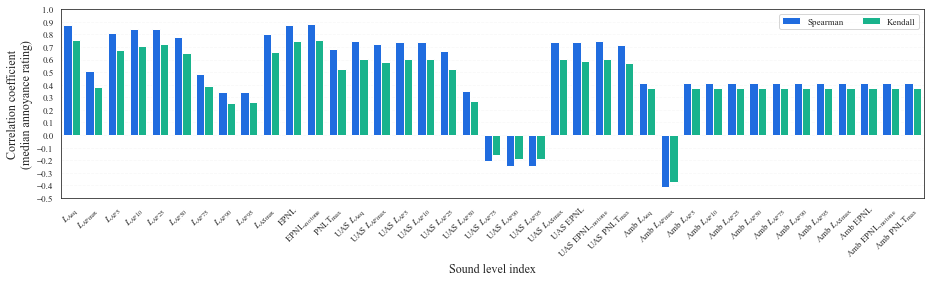

In [13]:
data = pd.DataFrame(data=[corr_matrixA[1].loc['AnnoyMedian', indicesAcoustic],
                          corr_matrixA[2].loc['AnnoyMedian', indicesAcoustic]],
                    index=["Spearman", "Kendall"])

fig, ax = plt.subplots(figsize=(13, 4))
sns.barplot(data=data.melt(var_name="Type",
                           ignore_index=False).reset_index(names="Method"),
            x='Type', y='value', hue='Method', width=0.75,
            palette=mycolours[0:2], ax=ax)
ax.set(yticks=np.arange(-0.5, 1.1, 0.1), xlabel="Sound level index",
       ylabel="Correlation coefficient" + "\n" + "(median annoyance rating)")
ax.set_xticks(ticks=range(len(labelsAcoustic)), labels=labelsAcoustic,
              rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='best', ncol=2)
ax.grid(alpha=0.15, linestyle='--', axis='y')
plt.show()


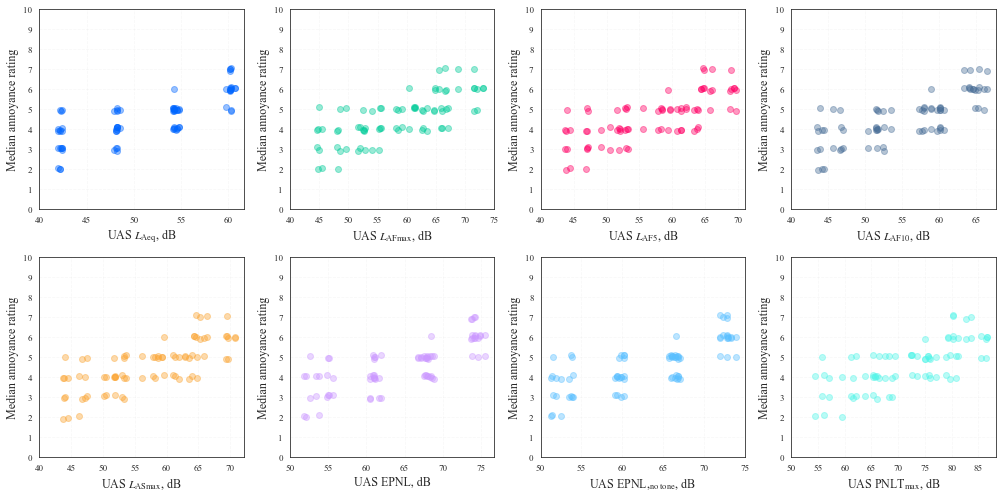

In [19]:
# scatter plots of sound level metrics with annoyance
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))
labelsAcousticSub = labelsAcoustic[13:17] + labelsAcoustic[22:26]
for ii, (index, ax) in enumerate(zip(indicesAcoustic[13:17]
                                     + indicesAcoustic[22:26],
                                     axs.ravel())):
    sns.regplot(data=ptADataForCorr, x=index, y='AnnoyMedian',
                ax=ax, y_jitter=0.1, color=mycolours[ii],
                scatter=True, fit_reg=False, scatter_kws=dict(alpha=0.4))
    ax.set(xticks=range(int(np.min(ptADataForCorr[index])/5)*5,
                        round(np.ceil(np.max(ptADataForCorr[index]))/5)*5 + 5,
                        5), yticks=range(0, 11),
           xlabel=labelsAcousticSub[ii] + ", dB",
           ylabel="Median annoyance rating")
    ax.grid(alpha=0.15, linestyle='--')

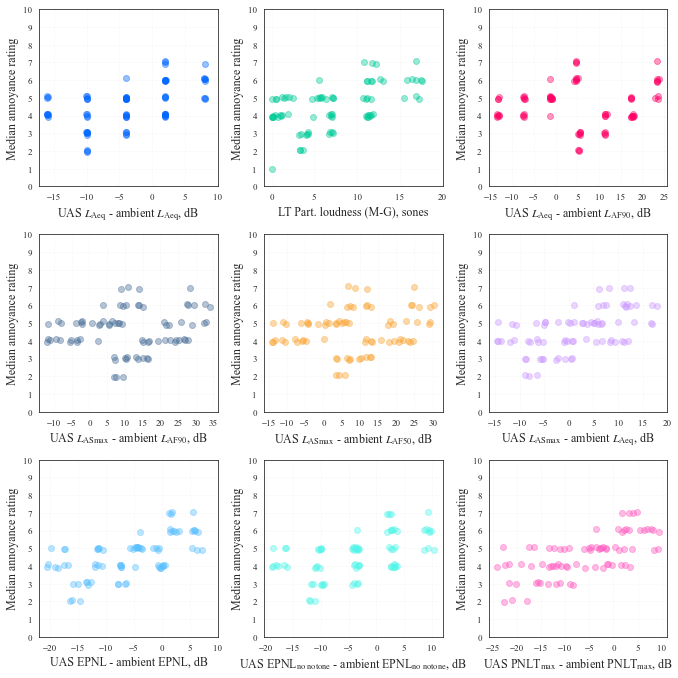

In [86]:
# scatter plots of difference metrics with annoyance
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(9.5, 19))

dictSNR = {0: "No UAS", 1: -16, 2: -10, 3: -4, 4: 2, 5: 8}
data = ptADataForCorr.copy()
data['SNRlevel'] = data['SNRlevel'].map(dictSNR)

for ii, (index, ax) in enumerate(zip(indicesDiff, axs.ravel())):
    if ii > len(indicesDiff):
        pass
    else:
        sns.regplot(data=pd.to_numeric(data[index], errors='coerce').to_frame().join(data['AnnoyMedian']), x=index, y='AnnoyMedian',
                    ax=ax, color=mycolours[ii], x_jitter=0.05, y_jitter=0.1,
                    scatter=True, fit_reg=False, scatter_kws=dict(alpha=0.4))
        ax.set(xticks=range(int((np.min(pd.to_numeric(data[index], errors='coerce').to_frame().join(data['AnnoyMedian']))-2)/5)*5,
                            round(np.ceil(np.max(pd.to_numeric(data[index], errors='coerce').to_frame().join(data['AnnoyMedian'])))/5)*5 + 5,
                            5), yticks=np.arange(0, 11),
               xlabel=labelsDiff[ii],
               ylabel="Median annoyance rating")
        ax.grid(alpha=0.15, linestyle='--')
plt.show()
